Import necessary libraries

In [1279]:
#import torch
from torchvision import transforms
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image 
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#from sklearn.manifold import MDS
from numpy import linalg as la
from datetime import datetime
import pickle
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [151]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="fancyimpute")

In [4]:
import ot

### Importing Dataset

In [1278]:
from huggingface_hub import login

# Replace with your own Hugging Face access token
my_token = "place_your_huggingface_token_here" 

login(token=my_token)

In [19]:
start = datetime.now()
print("Start Time:", start)

# Load ImageNet in streaming mode
ds_stream = load_dataset("ILSVRC/imagenet-1k", split="train", streaming=True)

# Access label names
label_names = ds_stream.features["label"].names

# Set random seed for reproducibility
random.seed(54)

# Select total nmumber of samples
total_samples = 1000

# Select specific classes

# Approach 1 : Randomly select labels
#selected_labels = random.sample(label_names, 2)
#print("Selected classes:", selected_labels)
#target_classes = [label_names.index(lbl) for lbl in selected_labels]

# Approach 2: Manaully select labels
target_classes = [215, 805] # Manually selecting labels
samples_per_class = total_samples // len(target_classes)


# Set random seed for reproducibility
random.seed(54)

# Reservoir sampling to pick samples from specific classes
samples = []
class_counts = {cls: 0 for cls in target_classes}
for i, example in enumerate(ds_stream):
    label = example['label']
    if label in target_classes and class_counts[label] < samples_per_class:
        if len(samples) < total_samples:
            samples.append(example)
            class_counts[label] += 1
        else:
            j = random.randint(0, i)
            if j < total_samples and class_counts[label] < samples_per_class:
                samples[j] = example
                class_counts[label] += 1
    if all(count >= samples_per_class for count in class_counts.values()):  # Stop when all classes are filled
        break
    #if i > 100000:  # Optional limit for speed
    #    break

print(f"Collected {len(samples)} random samples from classes {target_classes}: {class_counts}")

end = datetime.now()
print("End Time:", end)
print(f"Total Run-time: {end - start} HH:MM:SS:ms")

Start Time: 2025-10-29 23:36:24.369154


Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

/home/axk8440@uta.edu/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/axk8440@uta.edu/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Collected 1000 random samples from classes [215, 805]: {215: 500, 805: 500}
End Time: 2025-10-30 00:07:14.809072
Total Run-time: 0:30:50.439918 HH:MM:SS:ms


In [21]:
# Run this cell with caution
# Take a backup and save the dataset locally 
two_class_500 = samples

# Specify the path where you want to save the file
save_path = "/home/axk8440@uta.edu/Documents/CapstoneProject/ResolutionTest/Two_class_500.pkl"

# Save the dictionary to a file using pickle
with open(save_path, 'wb') as f:
    pickle.dump(two_class_500, f)

print(f"Data saved to {save_path}")

Data saved to /home/axk8440@uta.edu/Documents/CapstoneProject/ResolutionTest/Two_class_500.pkl


In [22]:
# Load the dictionary from the file using pickle
with open(save_path, 'rb') as f:
    loaded_samples = pickle.load(f)

print("Loaded dictionary from local drive")


Loaded dictionary from local drive


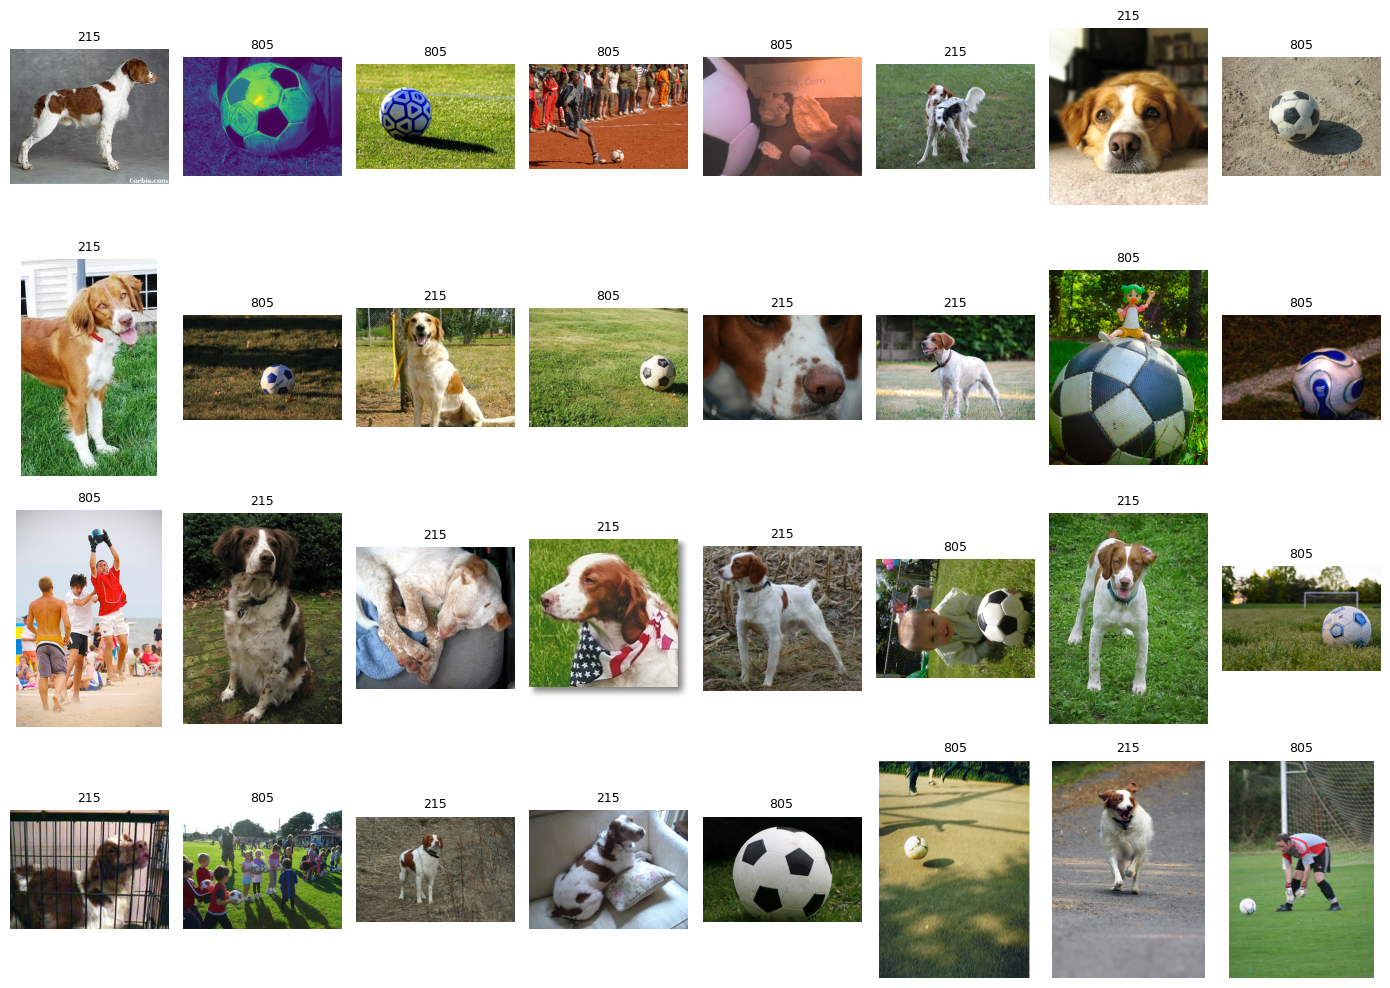

In [23]:
# Visualize sampled images in a grid
fig, axes = plt.subplots(4, 8, figsize=(14, 10))
#for ax, sample in zip(axes.flatten(), random.sample(samples, 25)):
for ax, sample in zip(axes.flatten(), samples):
    image = sample["image"]
    label_id = sample["label"]
    label_name = label_names[label_id]

    ax.imshow(image)
    ax.set_title(label_id, fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Data Pre-processing

In [24]:
# Summarize the resolutions and see unique sizes
resolutions = [sample["image"].size for sample in samples]
unique_res = set(resolutions)

print(f"\nTotal unique resolutions found: {len(unique_res)}")
for res in list(unique_res)[:10]:  # show first 10 unique ones
    print(f"Resolution: {res[0]} x {res[1]}")


Total unique resolutions found: 365
Resolution: 500 x 444
Resolution: 500 x 462
Resolution: 301 x 500
Resolution: 446 x 500
Resolution: 100 x 92
Resolution: 600 x 396
Resolution: 144 x 125
Resolution: 500 x 327
Resolution: 500 x 336
Resolution: 288 x 264


Target Distribution:
215    500
805    500
Name: count, dtype: int64


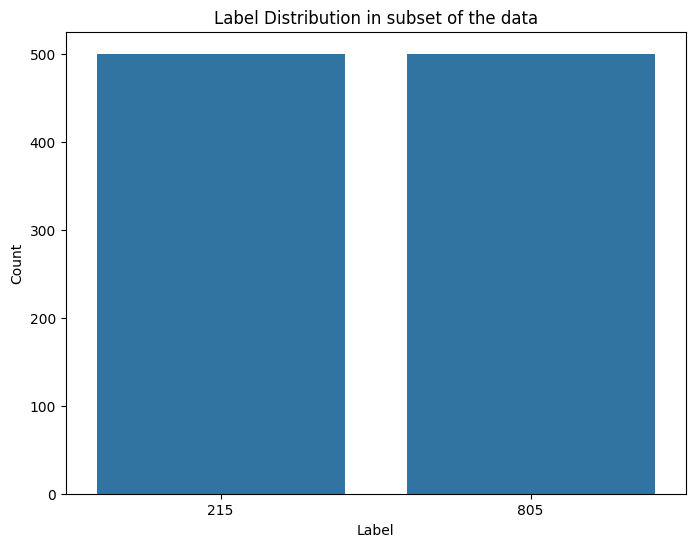

In [25]:
# Function to check for imbalance in Target column
def check_imbalance(df, flag=1):
  ''' Inputs to function:
  df   - dataset
  flag - 0 for whole dataset, 1 for subset
  '''
  if flag == 0:
    labels = [i["label"] for i in df["train"]]
  else:
    labels = [i["label"] for i in df]

  label_counts = pd.Series(labels).value_counts()
  print("Target Distribution:")
  print(label_counts)
  return label_counts


# Checking class imbalance in the subset
sub_label_counts = check_imbalance(samples)

# Visualize the label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sub_label_counts.index, y=sub_label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution in subset of the data")
plt.show()

In [26]:
samples[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x219>,
 'label': 215}

In [27]:
# Pre-processing
# Convert PIL images to NumPy arrays and standardize initial size
initial_size = 28 
sample_images = []

for sample in samples:
    img = np.array(sample['image'])  # Convert PIL to NumPy [H, W, 3] or [H, W] if grayscale
    
    # Check if the image is grayscale (2D) or RGB (3D)
    if len(img.shape) == 2:  # Grayscale image [H, W]
        # Resize the grayscale image
        img = zoom(img, (initial_size / img.shape[0], initial_size / img.shape[1]), order=1)
    elif len(img.shape) == 3:  # RGB image [H, W, 3]
        # Resize the RGB image, both height and width while keeping the color channels
        img = zoom(img, (initial_size / img.shape[0], initial_size / img.shape[1], 1), order=1)
    
    sample_images.append(img)

sample_labels = [sample['label'] for sample in samples]

In [30]:
# # Function to convert image to grayscale point cloud [x, y, w]
# def image_to_pointcloud(img):
#     if len(img.shape) == 3 and img.shape[2] == 3:
#         img = np.mean(img, axis=2)  # Convert to grayscale
#     size = img.shape[0]
#     grid_x, grid_y = np.mgrid[0:size:1, 0:size:1]
#     points = np.vstack((grid_x.ravel(), grid_y.ravel())).T
#     weights = img.ravel()
#     mask = weights > 0.01  # Threshold to reduce points
#     points = points[mask].copy()  # Ensure C-contiguity
#     weights = weights[mask].copy()  # Ensure C-contiguity
#     weights = weights / np.sum(weights) if np.sum(weights) > 0 else weights
#     return np.hstack((points, weights[:, np.newaxis]))

### Image to point-cloud conversion

##### Defining required functions

In [1282]:
# Main function
def image_to_pointcloud(img, threshold=0.01):
    """
    Convert a 2D or RGB image into a grayscale point cloud of [x, y, weight].
    
    Args:
        img (np.ndarray): Input image (H, W) or (H, W, 3)
        threshold (float): Pixel intensity threshold to filter out dark/insignificant points.
    
    Returns:
        np.ndarray: Point cloud of shape [N, 3] where each row is (x, y, weight)
    """
    # Convert RGB to Grayscale
    if img.ndim == 3 and img.shape[2] == 3:
        img = np.mean(img, axis=2)  # grayscale intensity (H, W)

    # Normalize pixel intensity (in case range is 0–255)
    if img.max() > 1.0:
        img = img / 255.0

    # Create coordinate grid
    size_y, size_x = img.shape  # handle non-square safely
    grid_x, grid_y = np.meshgrid(np.arange(size_x), np.arange(size_y))

    # Flatten into vectors
    points = np.vstack((grid_x.ravel(), grid_y.ravel())).T  # shape [H*W, 2]
    weights = img.ravel()

    # Optional filtering (removes near-zero intensity pixels)
    mask = weights > threshold
    points = points[mask].copy()
    weights = weights[mask].copy()

    # Normalize weights (so they sum to 1 for OT)
    total = np.sum(weights)
    if total > 0:
        weights = weights / total

    # Combine into single [x, y, w] array
    return np.hstack((points, weights[:, np.newaxis]))

# Fucntion to visualize the point-cloud
def visualize_point_cloud(point_cloud, title="Point Cloud Visualization"):
    """
    Visualize a grayscale point cloud [x, y, w] as a scatter plot.
    - x, y are pixel coordinates
    - w is normalized intensity/weight
    """
    # Extract coordinates and weights
    x, y, w = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]

    # Normalize weights for visualization
    w_scaled = w / w.max() if w.max() > 0 else w

    plt.figure(figsize=(5, 5))
    plt.scatter(
        x, y, 
        c=w_scaled, cmap='magma', s=20, alpha=0.8,
        edgecolor='none'
    )
    plt.gca().invert_yaxis()  # Image coordinates (top-left origin)
    plt.axis('equal')
    plt.colorbar(label="Normalized Intensity (w)")
    plt.title(title)
    plt.xlabel("x (pixel column)")
    plt.ylabel("y (pixel row)")
    plt.tight_layout()
    plt.show()

##### Point-cloud conversion

In [72]:
# Convert all images to point clouds
point_clouds = []
for img in tqdm(sample_images, desc="Converting to grayscale point clouds"):
    pc = image_to_pointcloud(img, threshold=0.01)
    point_clouds.append(pc)

print(f"Converted {len(point_clouds)} images to point clouds.")
print(f"Sample shape: {point_clouds[0].shape}") 

Converting to grayscale point clouds: 100%|█████████████████████████████| 1000/1000 [00:00<00:00, 5053.48it/s]

Converted 1000 images to point clouds.
Sample shape: (784, 3)


In [73]:
len(point_clouds)

1000

In [74]:
point_clouds[0][0]

array([0.       , 0.       , 0.0011421])

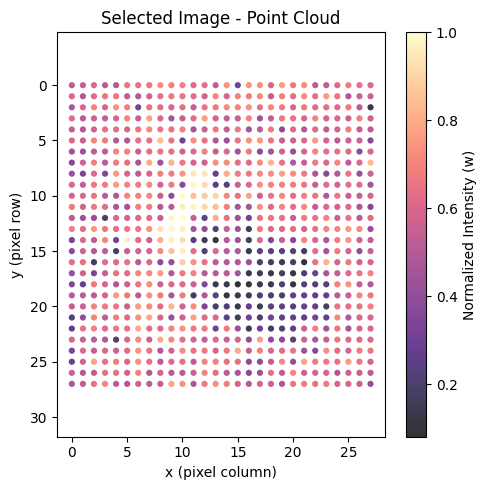

In [100]:

# Example: visualize the selected image's point cloud
visualize_point_cloud(point_clouds[7], title="Selected Image - Point Cloud")

### Wasserstein distance matrix computations

#### Defining required functions

In [1283]:
from matplotlib.colors import ListedColormap

# Visualze Wassertein distance matrix
def visualize_distance_matrix(
        W_partial,
        title="Wasserstein Distance Matrix",
        highlight_color='lime'):          # any matplotlib colour name / hex
    """
    Heat-map:
      • 0          → black
      • non-zero   → single highlight colour (no gradient)
      • no colour-bar
    Args:
        W_partial: np.ndarray of shape [N, N]
        title:     plot title
        highlight_color: colour for non-zero cells
    """
    plt.figure(figsize=(8, 7))
    # 1. Binary mask
    mask_nonzero = (W_partial != 0).astype(float)   # 1.0 = non-zero, 0.0 = zero
    # 2. Plot zeros → black background
    plt.imshow(np.zeros_like(W_partial),
               cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    # Create a colormap that maps 0 → black and 1 → highlight_color
    cmap = ListedColormap(['black', highlight_color])
    plt.imshow(mask_nonzero, cmap=cmap, vmin=0, vmax=1,
               interpolation='nearest', alpha=1.0)

    plt.title(title, fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")

    plt.tight_layout()
    plt.show()

In [758]:
# def visualize_distance_matrix(W_partial, title="Wasserstein Distance Matrix"):
#     """
#     Visualize a Wasserstein distance matrix as a heatmap.
#     Args:
#         W_partial: np.ndarray of shape [N, N]
#     """
#     plt.figure(figsize=(8, 7))
#     im = plt.imshow(W_partial, cmap='bone', interpolation='nearest')
#     plt.title(title, fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
#     plt.box(False)
#     plt.xlabel("Image Index")
#     plt.ylabel("Image Index")
#     plt.colorbar(im, label="Wasserstein Distance")
#     plt.tight_layout()
#     plt.show()

##### Funtions for Matrix recovery 

In [1285]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="fancyimpute")
from fancyimpute import SoftImpute

def MDS(distance_matrix, num_components = 2, squared = False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    num_components corresponds to the embedding dimension, which is defaulted to 2
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)    
    return embedding

# Matrix Completion using SoftImpute (Efficient Alternative)
def recover_with_softimpute(D_obs, mds_function = MDS):  # Modify to just return D_filled
    model = SoftImpute(verbose = False)
    D_filled = model.fit_transform(D_obs)
    # return embed_with_mds(D_filled)
    return D_filled #mds_function(D_filled)

# Generic Recovery Wrapper
def recover_matrix(D_obs, method = 'softimpute', mds_function = MDS):
    if method == 'cvx':
        rank = kwargs.get('rank', 2)
        return recover_low_rank_embedding(D_obs, rank)
    elif method == 'softimpute':
        return recover_with_softimpute(D_obs)
    else:
        raise ValueError(f"Unknown recovery method: {method}")

def compute_snr_db_masked(W_true, W_recon, mask_obs):
    mask = mask_obs.astype(bool)
    signal = np.linalg.norm(W_true[mask])
    noise = np.linalg.norm((W_true - W_recon)[mask])
    if noise <= 0:
        return np.inf
    return 20 * np.log10(signal / noise)

def compute_snr_db(W_true, W_recon):
    """
    Compute SNR (in dB) between ground truth and reconstructed distance matrices.
    """
    signal = np.linalg.norm(W_true)
    noise = np.linalg.norm(W_true - W_recon)
    if noise <= 0:
        return np.inf
    return 20 * np.log10(signal / noise)


def visualize_reconstructed_embedding(embedding, labels=None, title="Reconstructed Embedding (MDS)"):
    # Plot
    plt.figure(figsize=(7, 6))
    if labels is not None:
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                              c=labels, cmap='tab10', alpha=0.8)
        plt.legend(*scatter.legend_elements(), title="Classes", loc="best")
    else:
        plt.scatter(embedding[:, 0], embedding[:, 1], color='steelblue', alpha=0.8)

    plt.title(title)
    plt.xlabel("MDS Dim 1")
    plt.ylabel("MDS Dim 2")
    plt.grid(False)
    plt.show()
    return None


#----------- Main fucntion to apply Recovery and SNR computation------------
def matrix_recon_SNR(full_matrix, partial_matrix, see_embeddings=False):  
    tic = time.perf_counter()
    W_recon = recover_matrix(partial_matrix, method='softimpute')
    toc = time.perf_counter()
    total_recovery_time = toc - tic
    # Compute SNR
    snr_db = compute_snr_db(full_matrix, W_recon)
    #mask_obs = ~np.isnan(partial_matrix)
    #snr_db = compute_snr_db_masked(full_matrix, W_recon, mask_obs)
    print(f" SNR (in db) : {snr_db:.4f}; Total recovery time - {total_recovery_time:.4f} seconds")

    # # Notes: As per convo on 11/4/25 - MDS and reconstruction steps are not required for this experiment, hence commenting them out.
    # recovered_embedding = MDS(W_recon)
    # # Reconstruct distances from embedding
    # D_recon = squareform(pdist(recovered_embedding, metric='euclidean'))
    # snr_db_recon = compute_snr_db(full_matrix, D_recon)
    # print(f" SNR after MDS (in db) : {snr_db_recon:.4f}")

    if see_embeddings:
        recovered_embedding = MDS(W_recon)
        true_embedding = MDS(full_matrix) 
        visualize_reconstructed_embedding(recovered_embedding, labels=None, title="Reconstructed Distance Embedding")
        visualize_reconstructed_embedding(true_embedding, labels=None, title="True Distance Embedding")
        
    return snr_db, total_recovery_time

#### Compute full distance matrix

In [82]:
# Compute distance matrix for all point clouds
W_dist_matrix = compute_wasserstein_matrix_pot(point_clouds)
print("Wasserstein distance matrix shape:", W_dist_matrix.shape)

Computing Wasserstein distance matrix for 1000 point clouds using Sinkhorn...


Computing distances: 100%|█████████████████████████████████████████████| 1000/1000 [19:20:29<00:00, 69.63s/it]

Wasserstein distance matrix shape: (1000, 1000)


In [88]:
W_dist_matrix[0].shape

(1000,)

In [101]:
# Define the filename for saving
filename = 'ImageNet1000_fulldist_matrix_28x28.npy'

# Save the array to the specified file
np.save(filename, W_dist_matrix)

print(f"NumPy array saved to {filename}")

NumPy array saved to ImageNet1000_fulldist_matrix_28x28.npy


In [102]:
W_partial_uniform_dist = np.load('Uniform_partial_dist_matrix_28x28.npy')

In [103]:
W_partial_uniform_dist.shape

(1000, 1000)

In [200]:
# Compute with samples selected globally
W_uni3_partial_nan = compute_partial_wasserstein_matrix_global(point_clouds, sample_fraction=0.2, reg=1)
print("Distance matrix shape:", W_uni3_partial_nan.shape)

Global sampling selected 154779 points (20.0% of total 773898)
Computing Wasserstein distance matrix for 1000 point clouds using globally sampled points...


Computing distances: 100%|██████████████████████████████████████████████| 1000/1000 [5:55:48<00:00, 21.35s/it]

Distance matrix shape: (1000, 1000)


In [218]:
W_uni3_partial_nan

array([[       nan, 4.21083063, 2.80943545, ..., 2.8015463 , 3.22340064,
        3.73531732],
       [4.21083063,        nan, 3.78093875, ..., 4.60160025, 4.8755528 ,
        4.37668621],
       [2.80943545, 3.78093875,        nan, ..., 2.87163246, 3.65328819,
        2.95291622],
       ...,
       [2.8015463 , 4.60160025, 2.87163246, ...,        nan, 3.430323  ,
        3.23949958],
       [3.22340064, 4.8755528 , 3.65328819, ..., 3.430323  ,        nan,
        4.7414014 ],
       [3.73531732, 4.37668621, 2.95291622, ..., 3.23949958, 4.7414014 ,
               nan]])

## Main CCS testing

#### Defining necessary functions for CCS

In [1199]:
# Compute Wasserstein distance between two point clouds
def compute_wasserstein_distance(pc1, pc2, reg=1):
    """
    Takes in two pointclouds pc1 and pc2, i.e., pc1 = [x1,y1,w1;...;xp,yp,wp], etc. and computes the Wasserstein-2 distance
    between pc1 and pc2.
    """
    # Reshaping and stripping out (x,y) locations (Upts, Vpts) and weights (Uwts, Vwts)
    pc1pts = np.ascontiguousarray(pc1[:,0:2])
    pc2pts = np.ascontiguousarray(pc2[:,0:2])
    pc1wts = np.ascontiguousarray(pc1[:,2])
    pc2wts = np.ascontiguousarray(pc2[:,2])
    pc1wts = pc1wts/np.sum(pc1wts) # normalize to make a probability
    pc2wts = pc2wts/np.sum(pc2wts) # normalize to make a probability  
    M = ot.dist(pc1pts, pc2pts, metric = 'sqeuclidean')  # Compute squared euclidean distance on the pointcloud points
    W = ot.sinkhorn2(pc1wts,pc2wts, M, reg=reg) # Compute exact squared Wasserstein-2 distance between U and V  
    # -------------------------------------Debug----------------------------------------- #
    # print(f"Mean: pc1pts:{np.mean(pc1pts):.3f} | pc2pts:{np.mean(pc2pts):.3f} | \
    # pc1wts:{np.mean(pc1wts):.3f} | pc2wts:{np.mean(pc2wts):.3f} | \      
    # Mean(M):{np.mean(M):.3f} | Median(M):{np.median(M):.3f} | W2-Distance: {W:.2f}")    #
    # -------------------------------------Debug----------------------------------------- #
    return W

In [1276]:
def Wasserstein_Matrix(image_list, reg=1, squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N))  # initialize the distance matrix
    tic = time.perf_counter()
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = compute_wasserstein_distance(image_list[i], image_list[j], reg=reg)
                # print(f"Row:{i} | Column:{j} | Distance:{distance[i,j]:.2f}")  #------Debug 
            else:
                distance[i,j] = compute_wasserstein_distance(image_list[i], image_list[j], reg=reg)**.5
    distance += distance.T  
    toc = time.perf_counter()
    total_time = (toc - tic)/60
    print(f"Computed {distance.shape}-distance matrix in {total_time:.2f} mins")
    return distance

In [163]:
# ---------- Helper functions ----------
def set_default_params_CCS(params):
    """Set default parameters for CCS if missing."""
    defaults = {'p': 0.2, 'delta': 0.3}
    for k, v in defaults.items():
        params.setdefault(k, v)
    return params

def CCS(X, params_CCS, rng=None):
    """Cross-Concentrated Sampling (generic version)."""
    params_CCS = set_default_params_CCS(params_CCS)
    rng = np.random.default_rng(rng)
    p = params_CCS['p']
    delta = params_CCS['delta']
    m, n = X.shape
    num_c = round(n * delta)
    J_ccs = rng.choice(n, num_c, replace=False)
    C = X[:, J_ccs]
    ubc = min(num_c * m, int(np.ceil(p * num_c * m)))
    C_obs_ind = rng.choice(num_c * m, ubc, replace=False)
    C_Obs = np.zeros((m, num_c), dtype=X.dtype)
    C_Obs.flat[C_obs_ind] = C.flat[C_obs_ind]
    X_Omega_ccs = np.zeros((m, n), dtype=X.dtype)
    X_Omega_ccs[:, J_ccs] = C_Obs
    selected_indices = np.argwhere(X_Omega_ccs != 0)
    selected_indices = np.unique(selected_indices, axis=0)
    return X_Omega_ccs, J_ccs, selected_indices, C_obs_ind

In [1250]:
#---------Main function---------------#
def Wass_Matrix_CCS_Col(image_list, params_CCS, squared=True, rng=None, reg=1):
    """
    Compute a sparse Wasserstein Distance Matrix using CCS sampling, only from selected columns.   
    Parameters:
    - image_list: List of point clouds ([x, y, w] arrays).
    - p: Sampling probability within selected columns (default: 0.3).
    - delta: Fraction of columns to sample (default: 0.2).
    - squared: If True, compute squared Wasserstein distance; else, take square root.
    Returns:
    - distance: Sparse NxN NumPy array with Wasserstein distances.
    - J_ccs: Sampled column indices.
    - sampled_positions: Nx3 NumPy array of [row_idx, col_idx, distance] for sampled positions.
    """
    params_CCS = set_default_params_CCS(params_CCS)
    rng = np.random.default_rng(rng)
    p = params_CCS['p']
    delta = params_CCS['delta']
    N = len(image_list)
    distance = np.zeros((N, N))
    num_c = round(N * delta)
    J_ccs = rng.choice(N, num_c, replace=False)
    ubc = min(num_c * N, int(np.ceil(p * num_c * N)))
    C_obs_ind = rng.choice(num_c * N, ubc, replace=False)
    print(f"Sampling {ubc} column entries out of selected {num_c} columns")

    # Lists to store sampled positions and distances
    row_indices = []
    col_indices = []
    distances = []
    tic = time.perf_counter()

    for idx in C_obs_ind:
        i = idx // num_c
        j = idx % num_c
        j_full = J_ccs[j]
        if i != j_full:
            dist = compute_wasserstein_distance(point_clouds[i], point_clouds[j_full], reg=reg)
            computed_dist = dist if squared else np.sqrt(dist)
            distance[i, j_full] = computed_dist
            # print(f"Row:{i} | Column:{j_full} | Distance:{computed_dist:.2f}")  # -----Debug  
            row_indices.append(i)
            col_indices.append(j_full)
            distances.append(computed_dist)
        else:
            distance[i, j_full] = 0.0
            distance[j_full, i] = 0.0
    
    toc = time.perf_counter()
    total_time = (toc - tic)/60
    computed_entries = np.count_nonzero(distance)
    print(f"Computed {computed_entries}/{N*N} distances ({computed_entries/(N*N)*100:.2f}%) in {total_time:.2f} mins")
    # Combine indices and distances into Nx3 array
    sampled_positions = np.column_stack((row_indices, col_indices, distances))

    return distance, J_ccs, sampled_positions

##### Function for Column only ICURC

In [651]:
def set_default_params_ICURC(s):
    if 'TOL' not in s:
        s['TOL'] = 1e-4
    if 'max_ite' not in s:
        s['max_ite'] = 500
    if 'eta' not in s:
        s['eta'] = [1, 1, 1]
        s['steps_are1'] = True
    elif s['eta'] == [1, 1, 1]:
        s['steps_are1'] = True
    else:
        s['steps_are1'] = False
    return s

def ICURC(X_Omega, J_ccs, r, params_ICURC):
    params_ICURC = set_default_params_ICURC(params_ICURC)
    eta = params_ICURC['eta']
    #print(f'Using stepsize eta_C = {eta[0]:.6f}.')
    #print(f'Using stepsize eta_R = {eta[1]:.6f}.')
    #print(f'Using stepsize eta_U = {eta[2]:.6f}.')
    eta = params_ICURC['eta']
    TOL = params_ICURC['TOL']
    max_ite = params_ICURC['max_ite']
    steps_are1 = params_ICURC['steps_are1']

    Obs_U = X_Omega[np.ix_(J_ccs, J_ccs)]
    Obs_C = X_Omega[:, J_ccs]
    #Obs_R = X_Omega[I_ccs, :]

    # all_row_ind = np.arange(Obs_C.shape[0])
    # all_col_ind = np.arange(Obs_R.shape[1])

    # I_ccs_comp = np.setdiff1d(all_row_ind, I_ccs)
    # J_ccs_comp = np.setdiff1d(all_col_ind, J_ccs)

    # C = Obs_C[I_ccs_comp, :]
    # R = Obs_R[:, J_ccs_comp]

    #Smp_C = C != 0
    #Smp_R = R != 0
    #Smp_U = Obs_U != 0

    Smp_C = (Obs_C != 0)
    #Smp_R = R != 0
    Smp_U = (Obs_U != 0)


    #Omega_row = np.where(Smp_R.flatten())[0]
    Omega_col = np.where(Smp_C.flatten())[0]
    Omega_U = np.where(Smp_U.flatten())[0]

    #L_obs_row_vec = R.flatten()[Omega_row]
    L_obs_col_vec = Obs_C.flatten()[Omega_col]
    L_obs_U_vec = Obs_U.flatten()[Omega_U]

    normC_obs = np.linalg.norm(L_obs_col_vec)
    normU_obs = np.linalg.norm(L_obs_U_vec)
    #normR_obs = np.linalg.norm(L_obs_row_vec)
    #col_row_norm_sum = normC_obs + normU_obs + normR_obs
    col_norm_sum = normC_obs + normU_obs 

    if col_norm_sum == 0:
        col_norm_sum = 1.0

    U = Obs_U.copy()
    u, s, vh = np.linalg.svd(U, full_matrices=False)
    u = u[:, :r]
    vh = vh[:r, :]
    s = np.diag(s[:r])
    U = u @ s @ vh

    C = Obs_C.copy()

    fct_time = time.time()
    for ICURC_ite in range(1, max_ite + 1):
        ite_time = time.time()

        #R = u @ (u.T @ R)
        C = C @ (vh.T @ vh)

        U_flat = U.flatten()
        C_flat = C.flatten()
        # New_Error = (np.linalg.norm(R.flatten()[Omega_row] - L_obs_row_vec) +
        #              np.linalg.norm(C.flatten()[Omega_col] - L_obs_col_vec) +
        #              np.linalg.norm(U_flat[Omega_U] - L_obs_U_vec)) / col_row_norm_sum
        New_Error =  (np.linalg.norm(C_flat[Omega_col] - L_obs_col_vec) +
                     np.linalg.norm(U_flat[Omega_U] - L_obs_U_vec)) / col_norm_sum


        if New_Error < TOL or ICURC_ite == max_ite:
            ICURC_time = time.time() - fct_time
            # R_flat = R.flatten()
            # R_flat[Omega_row] = L_obs_row_vec
            # R = R_flat.reshape(R.shape)

            C_flat = C_flat.copy()
            C_flat[Omega_col] = L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat = U_flat.copy()
            U_flat[Omega_U] = L_obs_U_vec
            U = U_flat.reshape(U.shape)

            # Final_C = np.zeros_like(Obs_C)
            # Final_R = np.zeros_like(Obs_R)
            # Final_C[I_ccs_comp, :] = C
            # Final_R[:, J_ccs_comp] = R
            # Final_C[I_ccs, :] = U
            # Final_R[:, J_ccs] = U

            # C = Final_C
            # R = Final_R

            u, s, vh = np.linalg.svd(U, full_matrices=False)
            u = u[:, :r]
            vh = vh[:r, :]
            s = np.diag(s[:r])
            U_pinv = vh.T @ np.linalg.pinv(s) @ u.T

            #print(f'ICURC finished in {ICURC_ite} iterations, final error: {New_Error:.2e}, total runtime: {ICURC_time:.2f}s')
            return C, U_pinv, ICURC_time

        if not steps_are1:
            # R_flat = R.flatten()
            # R_flat[Omega_row] = (1 - eta[1]) * R_flat[Omega_row] + eta[1] * L_obs_row_vec
            # R = R_flat.reshape(R.shape)

            C_flat = C_flat.copy()
            C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat = U_flat.copy()
            U_flat[Omega_U] = (1 - eta[2]) * U_flat[Omega_U] + eta[2] * L_obs_U_vec
            U = U_flat.reshape(U.shape)

        else:
            # R_flat = R.flatten()
            # R_flat[Omega_row] = L_obs_row_vec
            # R = R_flat.reshape(R.shape)

            C_flat = C_flat.copy()
            C_flat[Omega_col] = L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat = U_flat.copy()
            U_flat[Omega_U] = L_obs_U_vec
            U = U_flat.reshape(U.shape)

        u, s, vh = np.linalg.svd(U, full_matrices=False)
        u = u[:, :r]
        vh = vh[:r, :]
        s = np.diag(s[:r])
        U = u @ s @ vh

        #print(f'Iteration {ICURC_ite}: error: {New_Error:.2e}, timer: {time.time() - ite_time:.2f}s')

##### Function for original ICURC

In [319]:
def set_default_params_ICURC(s):
    if 'TOL' not in s:
        s['TOL'] = 1e-4
    if 'max_ite' not in s:
        s['max_ite'] = 500
    if 'eta' not in s:
        s['eta'] = [1, 1, 1]
        s['steps_are1'] = True
    elif s['eta'] == [1, 1, 1]:
        s['steps_are1'] = True
    else:
        s['steps_are1'] = False
    return s

def ICURC_original(X_Omega, I_ccs, J_ccs, r, params_ICURC):
    params_ICURC = set_default_params_ICURC(params_ICURC)
    eta = params_ICURC['eta']
    print(f'Using stepsize eta_C = {eta[0]:.6f}.')
    print(f'Using stepsize eta_R = {eta[1]:.6f}.')
    print(f'Using stepsize eta_U = {eta[2]:.6f}.')
    eta = params_ICURC['eta']
    TOL = params_ICURC['TOL']
    max_ite = params_ICURC['max_ite']
    steps_are1 = params_ICURC['steps_are1']

    Obs_U = X_Omega[np.ix_(I_ccs, J_ccs)]
    Obs_C = X_Omega[:, J_ccs]
    Obs_R = X_Omega[I_ccs, :]

    all_row_ind = np.arange(Obs_C.shape[0])
    all_col_ind = np.arange(Obs_R.shape[1])

    I_ccs_comp = np.setdiff1d(all_row_ind, I_ccs)
    J_ccs_comp = np.setdiff1d(all_col_ind, J_ccs)

    C = Obs_C[I_ccs_comp, :]
    R = Obs_R[:, J_ccs_comp]

    Smp_C = C != 0
    Smp_R = R != 0
    Smp_U = Obs_U != 0

    Omega_row = np.where(Smp_R.flatten())[0]
    Omega_col = np.where(Smp_C.flatten())[0]
    Omega_U = np.where(Smp_U.flatten())[0]

    L_obs_row_vec = R.flatten()[Omega_row]
    L_obs_col_vec = C.flatten()[Omega_col]
    L_obs_U_vec = Obs_U.flatten()[Omega_U]

    normC_obs = np.linalg.norm(L_obs_col_vec)
    normU_obs = np.linalg.norm(L_obs_U_vec)
    normR_obs = np.linalg.norm(L_obs_row_vec)
    col_row_norm_sum = normC_obs + normU_obs + normR_obs

    U = Obs_U.copy()
    u, s, vh = np.linalg.svd(U, full_matrices=False)
    u = u[:, :r]
    vh = vh[:r, :]
    s = np.diag(s[:r])
    U = u @ s @ vh

    fct_time = time.time()
    for ICURC_ite in range(1, max_ite + 1):
        ite_time = time.time()

        R = u @ (u.T @ R)
        C = C @ vh.T @ vh

        U_flat = U.flatten()
        New_Error = (np.linalg.norm(R.flatten()[Omega_row] - L_obs_row_vec) +
                     np.linalg.norm(C.flatten()[Omega_col] - L_obs_col_vec) +
                     np.linalg.norm(U_flat[Omega_U] - L_obs_U_vec)) / col_row_norm_sum

        if New_Error < TOL or ICURC_ite == max_ite:
            ICURC_time = time.time() - fct_time
            R_flat = R.flatten()
            R_flat[Omega_row] = L_obs_row_vec
            R = R_flat.reshape(R.shape)

            C_flat = C.flatten()
            C_flat[Omega_col] = L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat[Omega_U] = L_obs_U_vec
            U = U_flat.reshape(U.shape)

            Final_C = np.zeros_like(Obs_C)
            Final_R = np.zeros_like(Obs_R)
            Final_C[I_ccs_comp, :] = C
            Final_R[:, J_ccs_comp] = R
            Final_C[I_ccs, :] = U
            Final_R[:, J_ccs] = U

            C = Final_C
            R = Final_R

            u, s, vh = np.linalg.svd(U, full_matrices=False)
            u = u[:, :r]
            vh = vh[:r, :]
            s = np.diag(s[:r])
            U_pinv = vh.T @ np.linalg.pinv(s) @ u.T

            print(f'ICURC finished in {ICURC_ite} iterations, final error: {New_Error:.2e}, total runtime: {ICURC_time:.2f}s')
            return C, U_pinv, R, ICURC_time

        if not steps_are1:
            R_flat = R.flatten()
            R_flat[Omega_row] = (1 - eta[1]) * R_flat[Omega_row] + eta[1] * L_obs_row_vec
            R = R_flat.reshape(R.shape)

            C_flat = C.flatten()
            C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat[Omega_U] = (1 - eta[2]) * U_flat[Omega_U] + eta[2] * L_obs_U_vec
            U = U_flat.reshape(U.shape)

        else:
            R_flat = R.flatten()
            R_flat[Omega_row] = L_obs_row_vec
            R = R_flat.reshape(R.shape)

            C_flat = C.flatten()
            C_flat[Omega_col] = L_obs_col_vec
            C = C_flat.reshape(C.shape)

            U_flat[Omega_U] = L_obs_U_vec
            U = U_flat.reshape(U.shape)

        u, s, vh = np.linalg.svd(U, full_matrices=False)
        u = u[:, :r]
        vh = vh[:r, :]
        s = np.diag(s[:r])
        U = u @ s @ vh

        #print(f'Iteration {ICURC_ite}: error: {New_Error:.2e}, timer: {time.time() - ite_time:.2f}s')

### Running tests

In [1251]:
#W_dist_matrix_100 = compute_wasserstein_matrix_pot(point_clouds[:100])
W_dist_matrix_100 = Wasserstein_Matrix(point_clouds[:100], reg=1, squared=True)
print("Wasserstein distance matrix shape:", W_dist_matrix_100.shape)

Computed (100, 100)-distance matrix in 8.74 mins
Wasserstein distance matrix shape: (100, 100)


In [1219]:
W_dist_matrix_50 = Wasserstein_Matrix(point_clouds[:50], reg=1, squared=True)

Computed (50, 50)-distance matrix in 2.17 mins


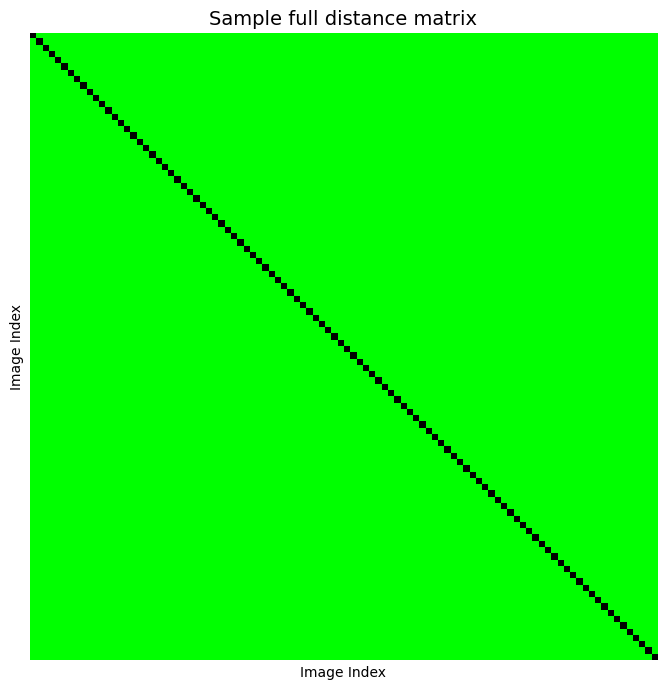

In [1252]:
#visualize_distance_matrix(W_dist_matrix_50, title="Sample full distance matrix")
visualize_distance_matrix(W_dist_matrix_100, title="Sample full distance matrix")
#W_dist_matrix_10

##### Original Col_CCS on a subset of data points

In [1253]:
params_CCS = {'p': 0.76, 'delta': 0.25}
params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 100
}
r = 4

# Run for all instances in the point_clouds
X_Omega_ccs_100, J_ccs_100, sampled_positions_100, C_Obs_100 = CCS(W_dist_matrix_100, params_CCS, rng=38)
#X_Omega_ccs_50, J_ccs_50, sampled_positions_50, C_Obs_50 = CCS(W_dist_matrix_50, params_CCS, rng=22)

##### Modified Col_CCS on a subset of data points

In [1222]:
params_CCS = {'p': 0.76, 'delta': 0.25}

# # Run for first 100 instances as input
# X_Omega_ccs_t100, J_ccs_t100, sampled_positions_t100 = Wass_Matrix_CCS_Col(point_clouds[:100],
#                                                                 params_CCS,
#                                                                 rng=22,
#                                                                 reg=1,
#                                                                 squared=True)

# print("J_ccs length:", len(J_ccs_t100))
# print("Total sampled_positions:\n", len(sampled_positions_t100))

# Run for first 50 instances as input
X_Omega_ccs_t50, J_ccs_t50, sampled_positions_t50 = Wass_Matrix_CCS_Col(point_clouds[:50],
                                                                params_CCS,
                                                                rng=22,
                                                                reg=1,
                                                                squared=True)

print("J_ccs length:", len(J_ccs_t50))
print("Total sampled_positions:\n", len(sampled_positions_t50))

Sampling 457 column entries out of selected 12 columns
Computed 448/2500 distances (17.92%) in 0.82 mins
J_ccs length: 12
Total sampled_positions:
 448


In [1254]:
params_CCS = {'p': 0.76, 'delta': 0.25}

# Run for first 100 instances as input
X_Omega_ccs_t100, J_ccs_t100, sampled_positions_t100 = Wass_Matrix_CCS_Col(point_clouds[:100],
                                                                params_CCS,
                                                                rng=38,
                                                                reg=1,
                                                                squared=True)

print("J_ccs length:", len(J_ccs_t100))
print("Total sampled_positions:\n", len(sampled_positions_t100))

Sampling 1900 column entries out of selected 25 columns
Computed 1879/10000 distances (18.79%) in 3.32 mins
J_ccs length: 25
Total sampled_positions:
 1879


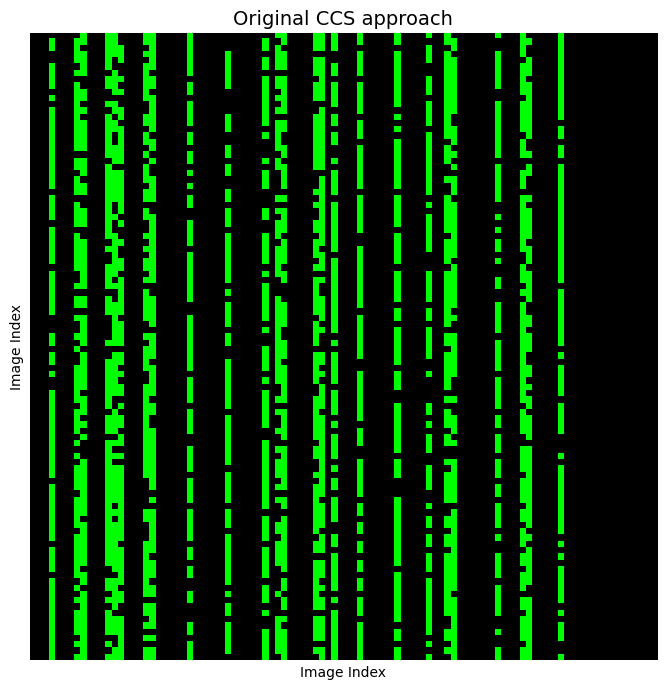

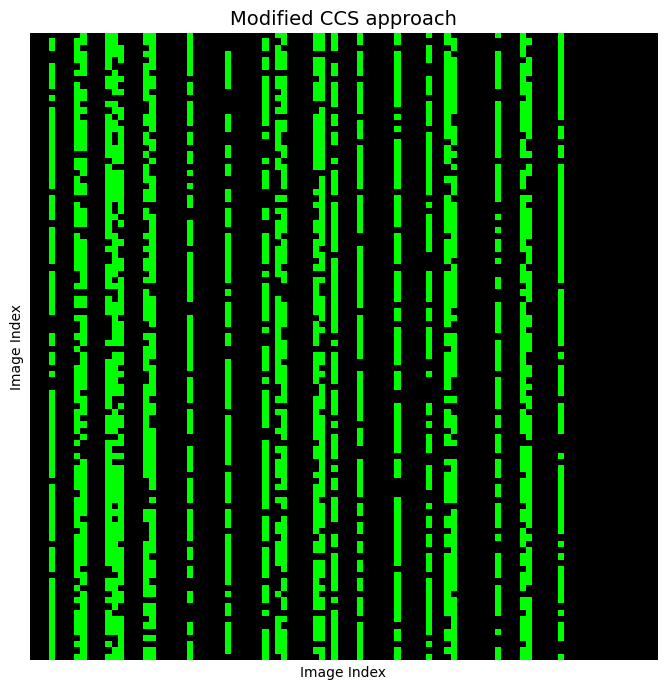

In [1255]:
visualize_distance_matrix(X_Omega_ccs_100, title="Original CCS approach")
visualize_distance_matrix(X_Omega_ccs_t100, title="Modified CCS approach")

In [1257]:
len(sampled_positions_100)

1879

In [1256]:
len(sampled_positions_t100)

1879

In [1263]:
print("Original")
print(X_Omega_ccs_100[0,:50])
print("\nModified")
print(X_Omega_ccs_t100[0,:50])

Original
[ 0.          0.          0.          0.          0.          0.
  0.          0.         10.14883796  0.          0.          0.
  7.2787564  15.95312854  0.          0.          0.          0.
 12.55438541  4.50858114  0.          0.          0.          0.
  0.         23.41891127  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          2.82421222  2.47774346  0.
  0.          0.          0.          9.31922215 35.70779565  0.
 18.67054188  0.        ]

Modified
[ 0.          0.          0.          0.          0.          0.
  0.          0.         10.14883796  0.          0.          0.
  7.2787564  15.95312854  0.          0.          0.          0.
 12.55438541  4.50858114  0.          0.          0.          0.
  0.         23.41891127  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          2.82421

In [1230]:
#X_Omega_ccs_100[0,:10]
X_Omega_ccs_50[0]

array([ 0.        ,  0.        ,  0.        ,  1.57730132,  0.        ,
        0.        ,  0.        ,  0.        , 10.14883796,  0.        ,
        0.        ,  5.42155493,  0.        ,  0.        ,  5.80869843,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  5.92706941,  0.        ,  0.        ,
        2.33977634,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.47774346,  0.        ,  0.        ,  0.        ,  0.        ,
        9.31922215,  0.        ,  0.        ,  0.        , 14.34545408])

In [1229]:
#X_Omega_ccs_t100[0,:10]
X_Omega_ccs_t50[0]

array([ 0.        ,  0.        ,  0.        ,  1.57730132,  0.        ,
        0.        ,  0.        ,  0.        , 10.14883796,  0.        ,
        0.        ,  5.42155493,  0.        ,  0.        ,  5.80869843,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  5.92706941,  0.        ,  0.        ,
        2.33977634,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.47774346,  0.        ,  0.        ,  0.        ,  0.        ,
        9.31922215,  0.        ,  0.        ,  0.        , 14.34545408])

In [1236]:
X_Omega_ccs_50[1] == X_Omega_ccs_t50[1]

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [1234]:
X_Omega_ccs_50[1]

array([14.17077718,  0.        ,  0.        , 15.65481156,  0.        ,
        0.        ,  0.        ,  0.        ,  9.35860715,  0.        ,
        0.        ,  9.64172939,  0.        ,  0.        , 10.48833352,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 21.650204  ,  0.        ,  0.        ,
       17.66286148,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       15.52293594,  0.        ,  0.        ,  0.        ,  0.        ,
       20.91381595,  0.        ,  0.        ,  0.        , 26.55157109])

In [1235]:
X_Omega_ccs_t50[1]

array([14.17045086,  0.        ,  0.        , 15.65481156,  0.        ,
        0.        ,  0.        ,  0.        ,  9.35860715,  0.        ,
        0.        ,  9.64172939,  0.        ,  0.        , 10.48833352,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 21.650204  ,  0.        ,  0.        ,
       17.66286148,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       15.52293594,  0.        ,  0.        ,  0.        ,  0.        ,
       20.91381595,  0.        ,  0.        ,  0.        , 26.55157109])

##### ICURC with original col_CCS

In [1272]:
# Run on a subset of point-clouds 
# Note: X_Omega_ccs_100 computed in above cells
params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 100
}
r = 4

# Run for all instances in the point_clouds
#X_Omega_ccs_f, J_ccs_f, sampled_positions_f, C_Obs_f = CCS(W_dist_matrix, params_CCS)
#visualize_distance_matrix(X_Omega_ccs_f, title="Column only CCS on full distance matrix")
#print("Matrix completion in progress.....")
C_100, U_pinv_100, ICURC_time_100 = ICURC(X_Omega_ccs_100, J_ccs_100, r, params_ICURC)
Mout_CURf_100 = C_100 @ U_pinv_100 @ C_100.T
#----------------Test---------------#
#np.fill_diagonal(Mout_CURf_100, 0) #
#----------------Test---------------#
# Compute Signal to Noise Ratio
ccs_100_snr = compute_snr_db(W_dist_matrix_100, Mout_CURf_100)
print(f" SNR (in db) : {ccs_100_snr:.4f}; Total recovery time - {ICURC_time_100:.4f} seconds")

 SNR (in db) : 21.2702; Total recovery time - 0.0255 seconds


##### ICURC with modified Col_CCS

In [1275]:
# Test updated ICURC with column only
C_t100, U_pinv_t100, ICURC_time_t100 = ICURC(X_Omega_ccs_t100, J_ccs_t100, r, params_ICURC)
Mout_CURf_t100 = C_t100 @ U_pinv_t100 @ C_t100.T
#----------------Test---------------#
np.fill_diagonal(Mout_CURf_t100, 0) #
#----------------Test---------------#
# Compute SNR
ccs_t100_snr = compute_snr_db(W_dist_matrix_100, Mout_CURf_t100)
print(f" SNR (in db) : {ccs_t100_snr:.4f}; Total recovery time - {ICURC_time_t100:.4f} seconds")

 SNR (in db) : 21.8060; Total recovery time - 0.0183 seconds


#### Debugging CCS inspired Partial Wass Matrix computation

In [1188]:
W_dist_matrix_5 = Wasserstein_Matrix(point_clouds[:5], reg=1, squared=True)

Mean: pc1pts:13.500 | pc2pts:13.231 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):262.188 | Median(M):205.000 | W2-Distance: 14.17
Row:0 | Column:1 | Distance:14.17
Mean: pc1pts:13.500 | pc2pts:13.495 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):261.325 | Median(M):205.000 | W2-Distance: 4.94
Row:0 | Column:2 | Distance:4.94
Mean: pc1pts:13.500 | pc2pts:13.500 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):261.000 | Median(M):205.000 | W2-Distance: 1.58
Row:0 | Column:3 | Distance:1.58
Mean: pc1pts:13.500 | pc2pts:13.500 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):261.000 | Median(M):205.000 | W2-Distance: 9.27
Row:0 | Column:4 | Distance:9.27
Mean: pc1pts:13.231 | pc2pts:13.495 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):262.527 | Median(M):205.000 | W2-Distance: 11.05
Row:1 | Column:2 | Distance:11.05
Mean: pc1pts:13.231 | pc2pts:13.500 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):262.188 | Median(M):205.000 | W2-Distance: 15.65
Row:1 | Column:3 | Distance:15.65
Mean

In [1195]:
#params_CCS = {'p': 1.0, 'delta': 1.0}
params_CCS = {'p': 0.76, 'delta': 0.25}
X_Omega_ccs_t5, J_ccs_t5, sampled_positions_t5 = Wass_Matrix_CCS_Col(point_clouds[:5],
                                                                params_CCS,
                                                                rng=5,
                                                                reg=1,
                                                                squared=True)

print("J_ccs length:", len(J_ccs_t5))
print("Total sampled_positions:\n", len(sampled_positions_t5))

Sampling 4 column entries out of selected 1 columns
Mean: pc1pts:13.495 | pc2pts:13.500 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):261.325 | Median(M):205.000 | W2-Distance: 4.98
Row:2 | Column:3 | Distance:4.98
Mean: pc1pts:13.231 | pc2pts:13.500 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):262.188 | Median(M):205.000 | W2-Distance: 15.65
Row:1 | Column:3 | Distance:15.65
Mean: pc1pts:13.500 | pc2pts:13.500 |     pc1wts:0.001 | pc2wts:0.001 |     Mean(M):261.000 | Median(M):205.000 | W2-Distance: 1.58
Row:0 | Column:3 | Distance:1.58
Computed 3/25 distances (12.00%) in 0.01 mins
J_ccs length: 1
Total sampled_positions:
 3


In [1196]:
params_CCS = {'p': 0.76, 'delta': 0.25}
params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 100
}
r = 4

# Run for all instances in the point_clouds
#X_Omega_ccs_20, J_ccs_20, sampled_positions_20, C_Obs_20 = CCS(W_dist_matrix_20, params_CCS, rng=5)
X_Omega_ccs_5, J_ccs_5, sampled_positions_5, C_Obs_5 = CCS(W_dist_matrix_5, params_CCS, rng=5)

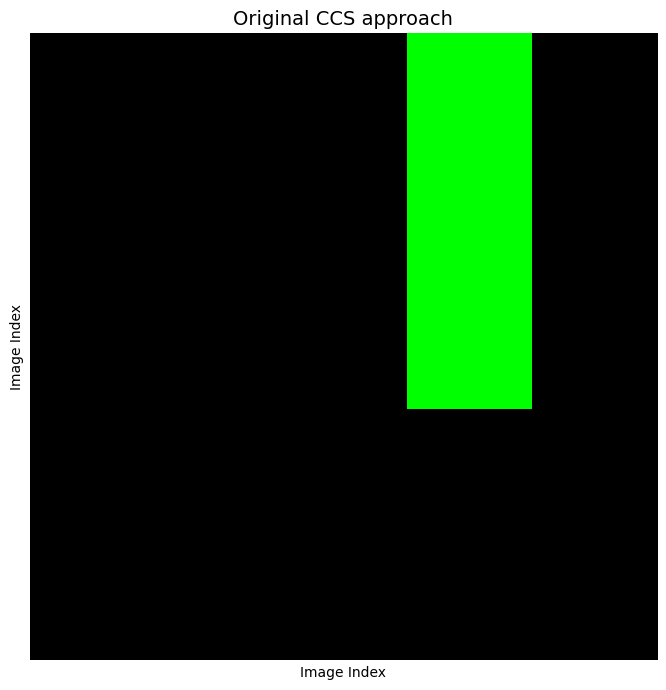

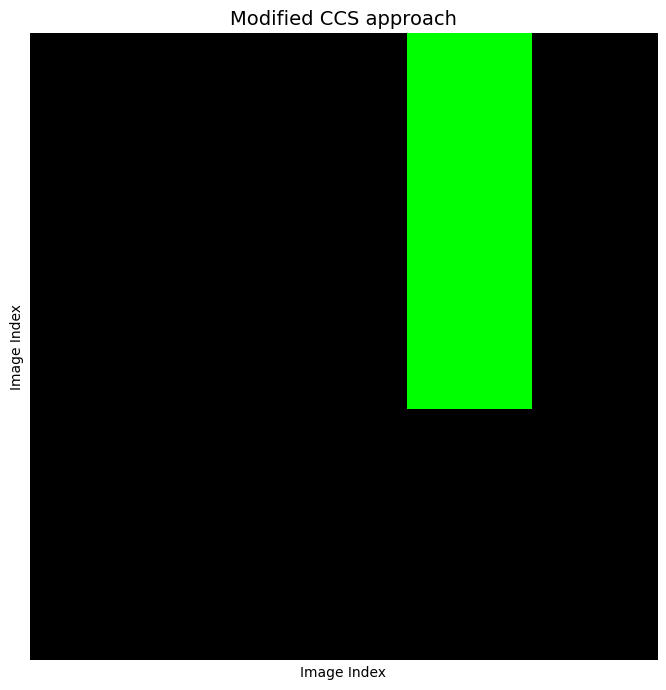

In [1191]:
visualize_distance_matrix(X_Omega_ccs_5, title="Original CCS approach")
visualize_distance_matrix(X_Omega_ccs_t5, title="Modified CCS approach")

In [1197]:
X_Omega_ccs_5

array([[ 0.        ,  0.        ,  0.        ,  1.57730132,  0.        ],
       [ 0.        ,  0.        ,  0.        , 15.65481156,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  4.98444065,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [1198]:
#X_Omega_ccs_t20[0,:20]
X_Omega_ccs_t5

array([[ 0.        ,  0.        ,  0.        ,  1.57730132,  0.        ],
       [ 0.        ,  0.        ,  0.        , 15.65481156,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  4.98444065,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

### Main test for Modified col_CCS and ICURC recovery on full data

In [833]:
params_CCS = {'p': 0.37, 'delta': 0.25}

# Run for all instances in the point_clouds
X_Omega_ccs, J_ccs, sampled_positions = Wass_Matrix_CCS_Col(point_clouds, 
                                                                p=params_CCS['p'],
                                                                delta=params_CCS['delta'],
                                                                seed=67,
                                                                reg=1,
                                                                squared=True)

Sampling 92500 column entries out of selected 250 columns
Computed 92413/1000000 distances (9.24%) in 168.76 mins


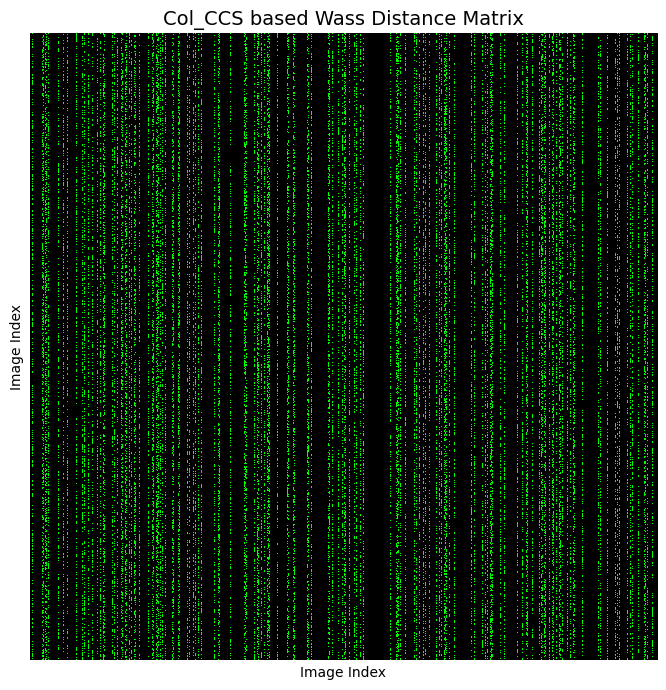

In [841]:
visualize_distance_matrix(X_Omega_ccs, title="Col_CCS based Wass Distance Matrix")

In [845]:
params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 100
}
r = 4
C, U_pinv, ICURC_time = ICURC(X_Omega_ccs, J_ccs, r, params_ICURC)
Mout_CURf = C @ U_pinv @ C.T

In [843]:
ccs_snr = compute_snr_db(W_dist_matrix, Mout_CURf)
print(f" SNR (in db) : {ccs_snr:.4f}; Total recovery time - {ICURC_time:.4f} seconds")

 SNR (in db) : -10.2642; Total recovery time - 1.1998 seconds


In [435]:
filename = "x_Omega_ccs_p3d2.npy"
np.save(filename, X_Omega_ccs)
print(f"Data saved successfully as {filename}")

Data saved successfully as x_Omega_ccs_p3d2.npy


In [436]:
params_CCS = {'p': 0.4, 'delta': 0.5}

# Run for all instances in the point_clouds
X_Omega_ccs2, J_ccs2, sampled_positions2 = Wass_Matrix_CCS_Col(point_clouds, 
                                                                p=params_CCS['p'],
                                                                delta=params_CCS['delta'],
                                                                seed=23,
                                                                reg=1,
                                                                squared=False)

Sampling 200000 column entries out of selected 500 columns
Computed 359646/1000000 distances (35.96%) in 624.24 mins


In [437]:
filename = "x_Omega_ccs_p4d5.npy"
np.save(filename, X_Omega_ccs2)
print(f"Data saved successfully as {filename}")

Data saved successfully as x_Omega_ccs_p4d5.npy


In [438]:
X_Omega_ccs.shape

(1000, 1000)

##### Trying Original ICURC code

In [453]:
# Original ICURC 
params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 500
}
r = 4
C_og, U_pinv_og, R_og, ICURC_time_og = ICURC_original(X_Omega_ccs, I_ccs, J_ccs, r, params_ICURC)
Mout_CURf_og = C_og @ U_pinv_og @ R_og

Using stepsize eta_C = 2.500000.
Using stepsize eta_R = 2.500000.
Using stepsize eta_U = 1.250000.
ICURC finished in 500 iterations, final error: 2.13e-01, total runtime: 247.31s


In [455]:
ccs_og_snr = compute_snr_db(W_dist_matrix, Mout_CURf_og)
print(f" SNR (in db) : {ccs_og_snr:.4f}; Total recovery time - {ICURC_time_og:.4f} seconds")

 SNR (in db) : 9.0450; Total recovery time - 247.3102 seconds


Reconstruction for p=0.4 and d=0.5

 Notes:
 - Remove softimpute from reconstruction algorothm and use Abiy's completion
 - Try higher p and delta values for CCS-ICURC
 - Verify the changes in Nystrom sampling code. (Executing) - Check with Muhammad)

### Running column only CCS on full distance matrix

In [528]:
W_dist_matrix.shape

(1000, 1000)

p*d*(n)^2

In [573]:
p=1
d=0.2
n=1000

tot_samples=p*d*(n)**2
fra_samples=(tot_samples/(n*n)*100)
print(f"Total no.of samples:{tot_samples}, Percentage:{fra_samples}%")

Total no.of samples:200000.0, Percentage:20.0%


#### Required functions for SNR vs (p,delta) vs Rank comparison

In [724]:
# Store SNR values for various p and delta values
def comapare_CCS_SNR(dist_matrix, pd_values_df, method=1, r=4):
    """
    This function takes in a full distance matrix and applied CCS-ICURC algorithm
    Computes Signal to Noise Ratio for various pre-computed p and delta values
    """  
    tot_n = dist_matrix.shape[0]
    pd_values_df["SNR"] = np.nan
    pd_values_df["RecoveryTime(secs)"] = np.nan
    pd_values_df["CCS_Sample%"] = np.nan
    # Iterate through different p and delta values from DataFrame
    for idx, row in pd_values_df.iterrows():
        params_CCS = {'p': row['p'], 'delta': row['delta']}
        #print(params_CCS)
        params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 100
        }
        # Apply column-only CCS on the full distance matrix
        X_Omega_CCS, J_CCS, sampled_positions, C_Obs = CCS(dist_matrix, params_CCS)
        X_Omega_ccs[np.ix_(J_ccs, J_ccs)] = dist_matrix[np.ix_(J_ccs, J_ccs)]
        C, U_pinv, ICURC_time = ICURC(X_Omega_CCS, J_CCS, r, params_ICURC)
        Mout_CURf = C @ U_pinv @ C.T
        ccs_snr = compute_snr_db(dist_matrix, Mout_CURf)  # Compute SNR
        # Assign SNR to the current row
        pd_values_df.at[idx, "SNR"] = round(ccs_snr,4)
        pd_values_df.at[idx, "RecoveryTime(secs)"] = round(ICURC_time,2)
        pd_values_df.at[idx, "CCS_Sample%"] = round((len(sampled_positions)/(tot_n*tot_n)*100),2)
    return pd_values_df

In [800]:
def show_snr_lineplot(df_input):
    """ Plots only non-zero and non-null SNR values"""
    #df = df_input.loc[df_input['SNR'] > 0]
    #df = df_input.where(df_input['SNR'] > 0).dropna()
    df=df_input.copy()
    # Create a new column for x-axis labels as (p, delta) pairs
    df['p_delta_pair'] = list(zip(df['p'], df['delta'], df['CCS_Sample%']))  # tuple pairs
    # OR as strings if you want nicer labels: "(p, delta)"
    df['p_delta_pair_str'] = df['p_delta_pair'].apply(lambda x: f"({x[0]:.2f}, {x[1]:.2f}, {x[2]:.1f})")

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df['p_delta_pair_str'], df['SNR'], marker='o', linestyle='-')
    plt.xticks(rotation=45, ha='right')  # rotate x-axis labels for readability
    plt.xlabel('(p, delta, Sample%)')
    plt.ylabel('SNR (dB)')
    plt.title('SNR for different (p, delta) pairs')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [984]:
def rank_snr_lineplot(df_input):
    """ Plots only non-zero and non-null SNR values"""
    #df = df_input.loc[df_input['SNR'] > 0]
    df = df_input.where(df_input['SNR'] > 0).dropna()
    """ Plots all SNR values"""
    #df=df_input.copy()
    # Create a new column for x-axis labels as (p, delta) pairs
    df['p_delta_rank'] = list(zip(df['p'], df['delta'], df['Rank']))  # tuple pairs
    # OR as strings if you want nicer labels: "(p, delta)"
    df['p_delta_pair_str'] = df['p_delta_rank'].apply(lambda x: f"({x[0]:.2f}, {x[1]:.2f}, {x[2]:.1f})")

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df['p_delta_pair_str'], df['SNR'], marker='o', linestyle='-')
    plt.xticks(rotation=90, ha='right')  # rotate x-axis labels for readability
    plt.xlabel('(p, delta, Rank)')
    plt.ylabel('SNR (dB)')
    plt.title('SNR for different (p, delta, rank) pairs')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [819]:
def show_snr_heatmap(df):
    # Create a pivot table for heatmap
    heatmap_data = df.pivot(index='delta', columns='p', values='SNR')
    plt.figure(figsize=(10,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis')
    plt.xlabel('p')
    plt.ylabel('delta')
    plt.title('SNR Heatmap')
    plt.show()

In [956]:
def rank_snr_heatmap(df_input, rounded_frac=True):
    """ Plots only non-zero and non-null SNR values"""
    #df = df_input.where(df_input['SNR'] > 0).dropna()
    """ Plots all SNR values"""
    df=df_input.copy()
    # Create a pivot table for heatmap
    if rounded_frac:
        heatmap_data = df.pivot(index='p_delta', columns='Rank', values='SNR')
    else:
        heatmap_data = df.pivot(index='CCS_Sample%', columns='Rank', values='SNR')    
    plt.figure(figsize=(10,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis')
    plt.xlabel('Rank')
    plt.ylabel('Sample Percentage')
    plt.title('SNR Heatmap')
    plt.show()

### Run Tests for Rank vs different (p, delta) setups

#### Initial setup

In [873]:
# Define target percentages
#fra_targets = np.arange(5,100,5) # 5% to 95%
#fra_targets = np.arange(10,32,2) # 10, 12, 14... 30%
fra_targets = np.arange(10,75,5)

# generate possible p and d values between 0 and 1
p_values = np.linspace(0.05, 1.0, 10)
#d_values = np.linspace(0.05, 1.0, 20)
d_values = np.arange(0.1,0.75,0.05)

# Store different rank values
ranks = [4,6,8,10,15,20]

# Store results
results = {}
for fra in fra_targets:
    target = fra / 100  # convert to fraction
    pairs = []
    for p in p_values:
        for d in d_values:
            if abs(p * d - target) < 0.01 and 0 < d < 1:
                pairs.append((round(p, 2), round(d, 2)))
    results[fra] = pairs
# Convert into a DataFrame
rows = []
for fra, pairs in results.items():
    for p, d in pairs:
        rows.append({"SamplePercentage": fra, "p": p, "delta": d})

df = pd.DataFrame(rows, columns=["p", "delta", "SamplePercentage"])
#unique_df = df.drop_duplicates(subset="Sample_Percentage", keep="first").reset_index(drop=True)
#unique_df = df.groupby("Sample_Percentage", as_index=False)[["p", "delta"]].median()
unique_df = df.groupby("SamplePercentage", as_index=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
#unique_df

In [877]:
#unique_df

In [914]:
import warnings
warnings.filterwarnings('ignore')

ranks = [4,6,8,10,15,20]       # Store different rank values
results = []                   # list to store results
rank_df = pd.DataFrame()

# Running the test
start = time.perf_counter()
for rank in ranks:
    snr_df = comapare_CCS_SNR(W_dist_matrix, unique_df.copy(), method=1, r=rank)
    snr_df["Rank"] = rank               
    results.append(snr_df)      # store the df

rank_df = pd.concat(results, ignore_index=False)
end = time.perf_counter()
print(f"Total test run-time: {(end - start)/60:.2f} mins")

Total test run-time: 6.70 mins


In [987]:
full_rank_df[full_rank_df['Rank']==20]

p  delta  SamplePercentage      SNR  RecoveryTime(secs)  CCS_Sample%  \
0   0.16   0.60                10      NaN                5.23         9.59   
1   0.16   0.65                10      NaN                6.41        10.39   
2   0.16   0.70                10      NaN                7.28        11.19   
3   0.26   0.35                10      NaN                1.97         9.09   
4   0.26   0.40                10      NaN                2.46        10.39   
5   0.37   0.25                10     -inf                1.05         9.24   
6   0.47   0.20                10 -10.3410                0.72         9.39   
7   0.68   0.15                10  24.5629                0.44        10.19   
8   1.00   0.10                10  33.6399                0.21         9.99   
9   0.26   0.55                15      NaN                4.95        14.28   
10  0.26   0.60                15      NaN                5.76        15.58   
11  0.37   0.40                15     -inf                2.47        14.79   
12  0.47   0.30                15 -14.6692                1.55        14.09   
13  0.58   0.25                15  21.5519                1.07        14.48   
14  0.79   0.20                15  26.4594                0.74        15.78   
15  1.00   0.15                15  34.2725                0.48        14.99   
16  0.37   0.55                20     -inf                4.94        20.33   
17  0.58   0.35                20  23.4760                1.98        20.28   
18  0.68   0.30                20  25.5411                1.50        20.38   
19  0.79   0.25                20  25.3494                1.09        19.73   
20  1.00   0.20                20  34.6958                0.74        19.98   
21  0.37   0.70                25     -inf                8.02        25.88   
22  0.47   0.55                25 -23.5869                5.01        25.83   
23  1.00   0.25                25  34.6936                1.14        24.98   
24  0.47   0.65                30 -18.2911                6.99        30.52   
25  0.68   0.45                30  26.7890                3.22        30.57   
26  1.00   0.30                30  34.7090                1.60        29.97   
27  0.58   0.60                35  22.1086                5.84        34.77   
28  0.68   0.50                35  25.1884                4.03        33.97   
29  0.79   0.45                35  27.4590                3.26        35.51   
30  0.89   0.40                35  29.4637                2.56        35.56   
31  1.00   0.35                35  34.8019                2.04        34.97   
32  0.58   0.70                40  24.1847                8.10        40.56   
33  0.79   0.50                40  28.2180                4.03        39.46   
34  0.89   0.45                40  31.0485                3.29        40.01   
35  1.00   0.40                40  34.7819                2.57        39.96   
36  0.68   0.65                45  25.4124                7.11        44.16   
37  0.89   0.50                45  31.2299                4.04        44.46   
38  1.00   0.45                45  34.8579                3.32        44.95   
39  0.89   0.55                50  29.5536                5.14        48.90   
40  1.00   0.50                50  34.9796                4.12        49.95   
41  0.79   0.70                55  28.0660                8.15        55.24   
42  1.00   0.55                55  34.9929                5.17        54.95   
43  1.00   0.60                60  34.9866                6.01        59.94   
44  1.00   0.65                65  35.0189                7.16        64.94   
45  1.00   0.70                70  35.0316                8.11        69.93   

    Rank  
0     20  
1     20  
2     20  
3     20  
4     20  
5     20  
6     20  
7     20  
8     20  
9     20  
10    20  
11    20  
12    20  
13    20  
14    20  
15    20  
16    20  
17    20  
18    20  
19    20  
20    20  
21    20  
22    20  
23    20  
24    20  
25    2

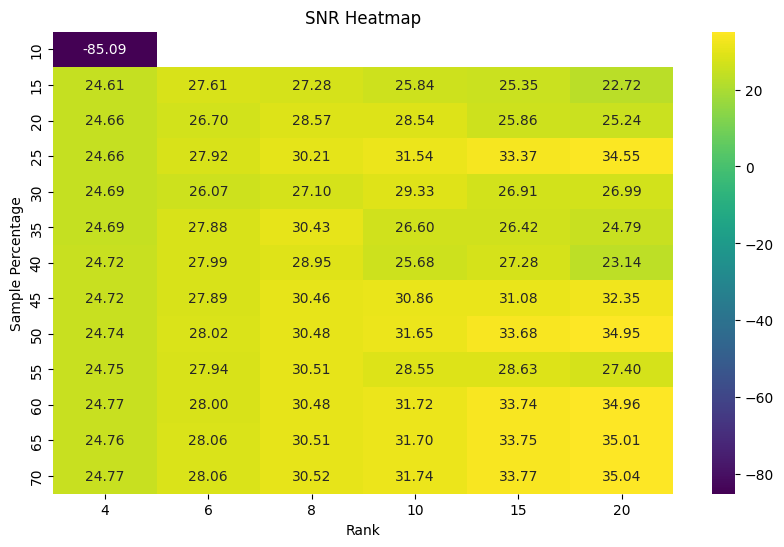

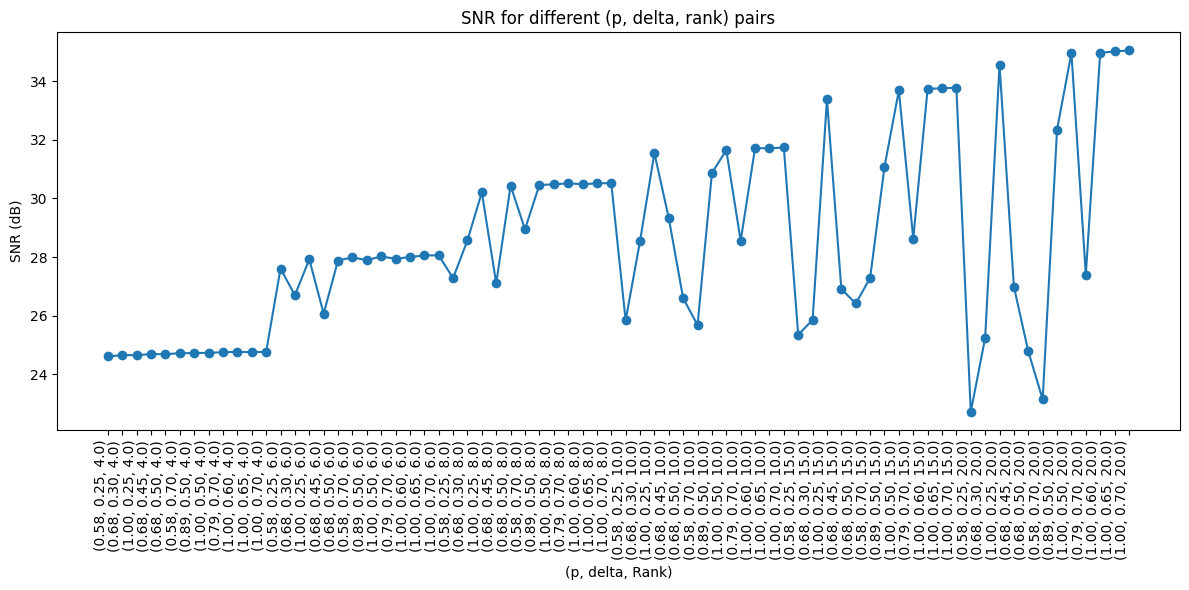

In [985]:
rank_snr_heatmap(rank_df, rounded_frac=True)
rank_snr_lineplot(rank_df)

#### Running for all possiblities of (p, delta) for all Sample%

In [978]:
import warnings
warnings.filterwarnings('ignore')

ranks = [4,6,8,10,15,20]       # Store different rank values
results = []                   # list to store results
full_rank_df = pd.DataFrame()

# Running the test
start = time.perf_counter()
for rank in ranks:
    snr_df = comapare_CCS_SNR(W_dist_matrix, df.copy(), method=1, r=rank)
    snr_df["Rank"] = rank               
    results.append(snr_df)      # store the df

full_rank_df = pd.concat(results, ignore_index=False)
end = time.perf_counter()
print(f"Total test run-time: {(end - start)/60:.2f} mins")

Total test run-time: 18.38 mins


In [979]:
full_rank_df

p  delta  SamplePercentage      SNR  RecoveryTime(secs)  CCS_Sample%  \
0   0.16   0.60                10      NaN                4.88         9.59   
1   0.16   0.65                10  24.3110                6.90        10.39   
2   0.16   0.70                10      NaN                6.67        11.19   
3   0.26   0.35                10  24.2935                1.96         9.09   
4   0.26   0.40                10  24.4571                2.45        10.39   
..   ...    ...               ...      ...                 ...          ...   
41  0.79   0.70                55  28.0660                8.15        55.24   
42  1.00   0.55                55  34.9929                5.17        54.95   
43  1.00   0.60                60  34.9866                6.01        59.94   
44  1.00   0.65                65  35.0189                7.16        64.94   
45  1.00   0.70                70  35.0316                8.11        69.93   

    Rank  
0      4  
1      4  
2      4  
3      4  
4      4  
..   ...  
41    20  
42    20  
43    20  
44    20  
45    20  

[276 rows x 7 columns]

In [981]:
#rank_snr_heatmap(full_rank_df, rounded_frac=True)

For each p and delta values:
- Sample and reconstruct 20 times without using the same seed.
- Plot mean+-std_dev of SNR for each p, delta values.

#### Checking for different values of p and delta for 10% Sample Scenario

In [921]:
df_10 = df[df['SamplePercentage']==10]

In [922]:
df_10

p  delta  SamplePercentage
0  0.16   0.60                10
1  0.16   0.65                10
2  0.16   0.70                10
3  0.26   0.35                10
4  0.26   0.40                10
5  0.37   0.25                10
6  0.47   0.20                10
7  0.68   0.15                10
8  1.00   0.10                10

In [923]:
import warnings
warnings.filterwarnings('ignore')

ranks = [4,6,8,10,15,20]       # Store different rank values
results = []                   # list to store results
rank_df_10 = pd.DataFrame()

# Running the test
start = time.perf_counter()
for rank in ranks:
    snr_df = comapare_CCS_SNR(W_dist_matrix, df_10.copy(), method=1, r=rank)
    snr_df["Rank"] = rank               
    results.append(snr_df)      # store the df

rank_df_10 = pd.concat(results, ignore_index=False)
end = time.perf_counter()
print(f"Total test run-time: {(end - start)/60:.2f} mins")

Total test run-time: 2.60 mins


In [950]:
rank_df_10.describe().T

count       mean       std    min      25%      50%  \
p                    54.0   0.391111  0.272408   0.16   0.1600   0.2600   
delta                54.0   0.377778  0.214271   0.10   0.2000   0.3500   
SamplePercentage     54.0  10.000000  0.000000  10.00  10.0000  10.0000   
SNR                  27.0       -inf       NaN   -inf  -7.1506  24.3831   
RecoveryTime(secs)   54.0   2.780370  2.466813   0.22   0.7125   1.9700   
CCS_Sample%          54.0   9.940000  0.644571   9.09   9.3900   9.9900   
Rank                 54.0  10.500000  5.520972   4.00   6.0000   9.0000   

                        75%      max  
p                    0.4700   1.0000  
delta                0.6000   0.7000  
SamplePercentage    10.0000  10.0000  
SNR                 26.1018  33.7137  
RecoveryTime(secs)   5.1275   7.1200  
CCS_Sample%         10.3900  11.1900  
Rank                15.0000  20.0000

In [983]:
rank_df_10

p  delta  SamplePercentage       SNR  RecoveryTime(secs)  CCS_Sample%  \
0  0.16   0.60                10       NaN                5.00         9.59   
1  0.16   0.65                10   15.3815                6.90        10.39   
2  0.16   0.70                10       NaN                6.59        11.19   
3  0.26   0.35                10   24.3831                1.96         9.09   
4  0.26   0.40                10   24.4656                2.49        10.39   
5  0.37   0.25                10   24.3391                1.05         9.24   
6  0.47   0.20                10   24.1597                0.72         9.39   
7  0.68   0.15                10   24.3786                0.44        10.19   
8  1.00   0.10                10   24.4344                0.22         9.99   
0  0.16   0.60                10       NaN                4.89         9.59   
1  0.16   0.65                10       NaN                5.95        10.39   
2  0.16   0.70                10       NaN                6.76        11.19   
3  0.26   0.35                10       NaN                1.96         9.09   
4  0.26   0.40                10       NaN                2.49        10.39   
5  0.37   0.25                10 -166.7765                1.06         9.24   
6  0.47   0.20                10   27.4875                0.72         9.39   
7  0.68   0.15                10   26.1997                0.43        10.19   
8  1.00   0.10                10   27.1562                0.22         9.99   
0  0.16   0.60                10       NaN                5.06         9.59   
1  0.16   0.65                10       NaN                5.95        10.39   
2  0.16   0.70                10       NaN                6.64        11.19   
3  0.26   0.35                10       NaN                1.99         9.09   
4  0.26   0.40                10       NaN                2.50        10.39   
5  0.37   0.25                10      -inf                1.05         9.24   
6  0.47   0.20                10   -3.5362                0.72         9.39   
7  0.68   0.15                10   25.7396                0.43        10.19   
8  1.00   0.10                10   29.6489                0.22         9.99   
0  0.16   0.60                10       NaN                5.03         9.59   
1  0.16   0.65                10       NaN                6.15        10.39   
2  0.16   0.70                10       NaN                6.82        11.19   
3  0.26   0.35                10       NaN                2.01         9.09   
4  0.26   0.40                10       NaN                2.49        10.39   
5  0.37   0.25                10      -inf                1.05         9.24   
6  0.47   0.20                10  -10.7650                0.72         9.39   
7  0.68   0.15                10   26.0039                0.43        10.19   
8  1.00   0.10                10   30.4051                0.22         9.99   
0  0.16   0.60                10       NaN                5.15         9.59   
1  0.16   0.65                10       NaN                6.17        10.39   
2  0.16   0.70                10       NaN                6.99        11.19   
3  0.26   0.35                10       NaN                1.97         9.09   
4  0.26   0.40                10       NaN                2.50        10.39   
5  0.37   0.25                10      -inf                1.05         9.24   
6  0.47   0.20                10  -20.6335                0.71         9.39   
7  0.68   0.15                10   24.4189                0.43        10.19   
8  1.00   0.10                10   32.5762                0.22         9.99   
0  0.16   0.60                10       NaN                5.30         9.59   
1  0.16   0.65                10       NaN                6.33        10.39   
2  0.16   0.70                10       NaN                7.12        11.19   
3  0.26   0.35                10       NaN                1.97         9.09   
4  0.26   0.40                10       NaN              

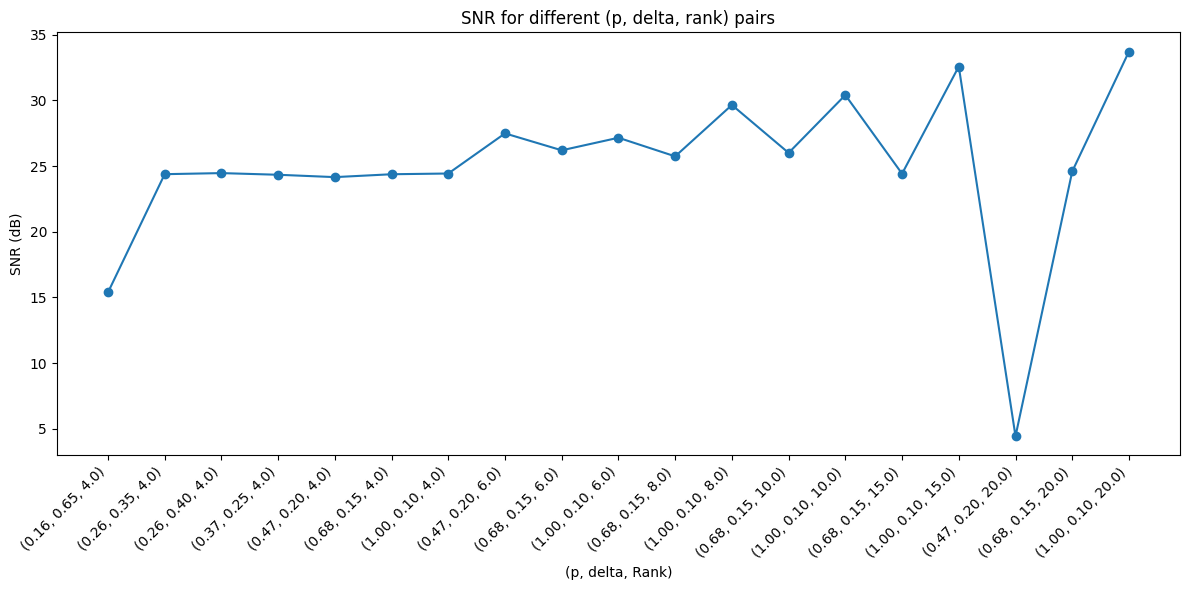

In [959]:
rank_snr_lineplot(rank_df_10)

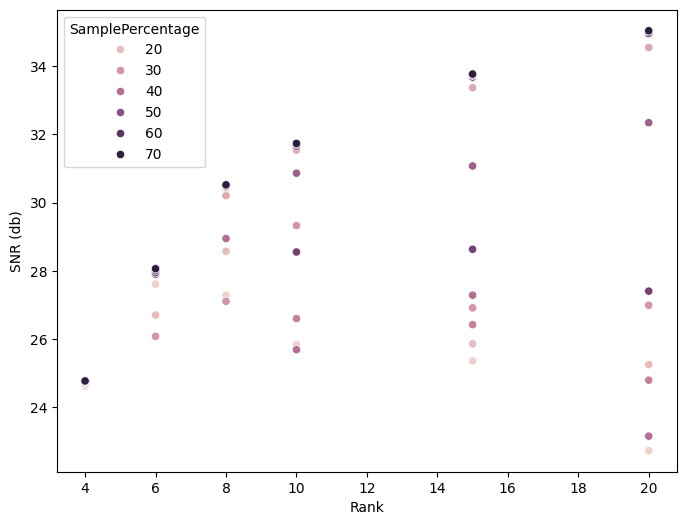

In [977]:
cleaned_rank_df = rank_df.where(rank_df['SNR'] > 0).dropna()
plt.figure(figsize=(8,6))
# sns.scatterplot(data=cleaned_rank_df, x="SamplePercentage", y="SNR", hue="Rank", palette="deep")
# plt.xlabel("Sample%")
sns.scatterplot(data=cleaned_rank_df, x="Rank", y="SNR", hue="SamplePercentage")
plt.xlabel("Rank")
plt.ylabel("SNR (db)")
plt.show()

In [965]:
cleaned_rank_df = rank_df.where(rank_df['SNR'] > 0).dropna()

#### r=4

In [896]:
snr_unique_df_r4 = comapare_CCS_SNR(W_dist_matrix, unique_df, method=1, r=4)

In [897]:
snr_unique_df_r4

p  delta  SamplePercentage      SNR  RecoveryTime(secs)  CCS_Sample%
0   0.16   0.65                10      NaN                5.86        10.39
1   0.58   0.25                15  24.5835                1.09        14.49
2   0.68   0.30                20  24.5952                1.50        20.38
3   1.00   0.25                25  24.5923                1.15        24.98
4   0.68   0.45                30  24.6727                3.26        30.57
5   0.68   0.50                35  24.6733                4.01        33.97
6   0.58   0.70                40  24.7143                8.00        40.56
7   0.89   0.50                45  24.7321                4.12        44.45
8   1.00   0.50                50  24.7303                4.14        49.95
9   0.79   0.70                55  24.7541                8.12        55.25
10  1.00   0.60                60  24.7566                6.01        59.94
11  1.00   0.65                65  24.7557                7.21        64.94
12  1.00   0.70                70  24.7689                8.17        69.93

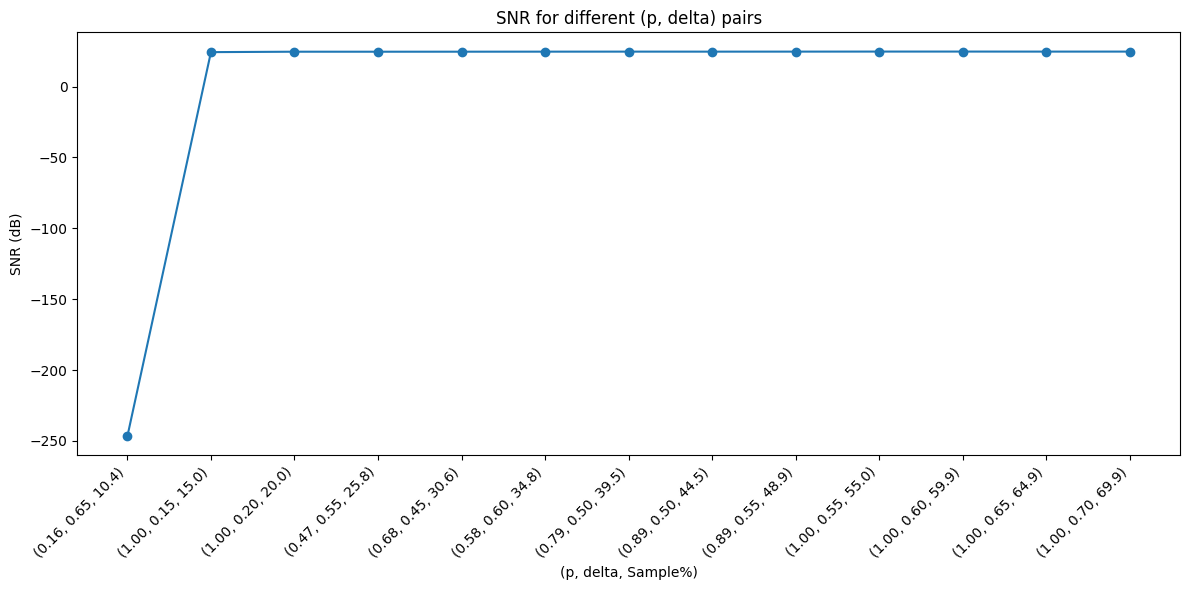

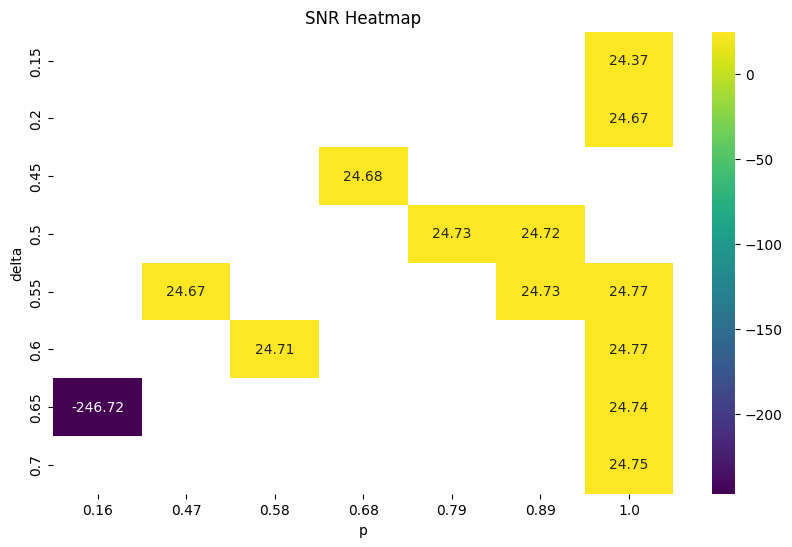

In [824]:
show_snr_lineplot(snr_unique_df_r4)
show_snr_heatmap(snr_unique_df_r4)

In [825]:
# Run for full dataframe
snr_full_df_r4 = comapare_CCS_SNR(W_dist_matrix, df, method=1, r=4)

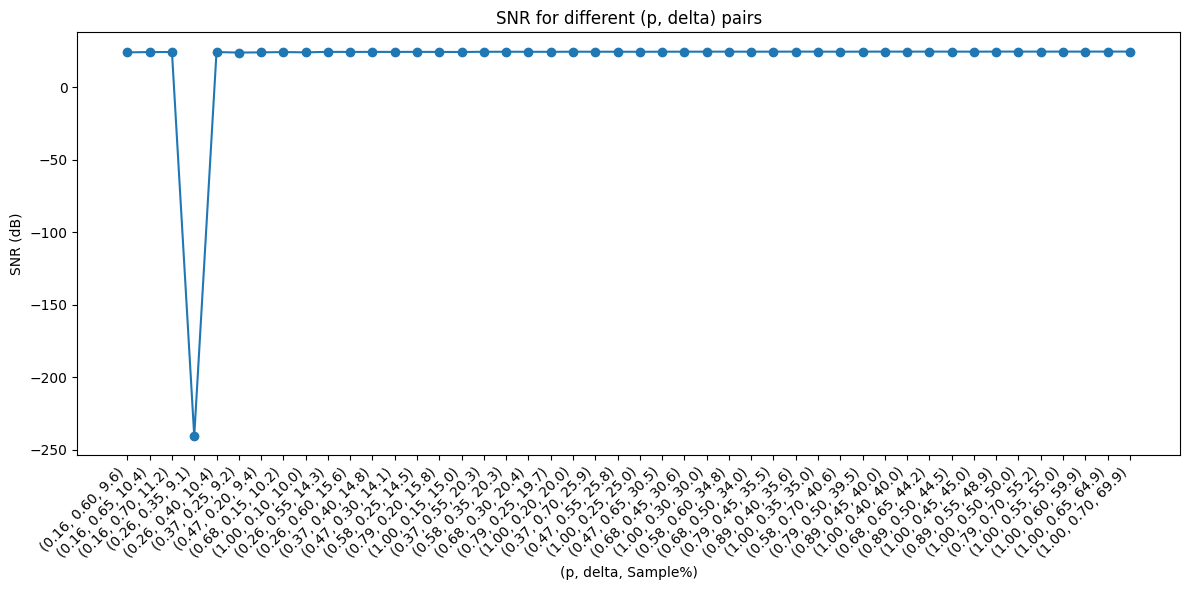

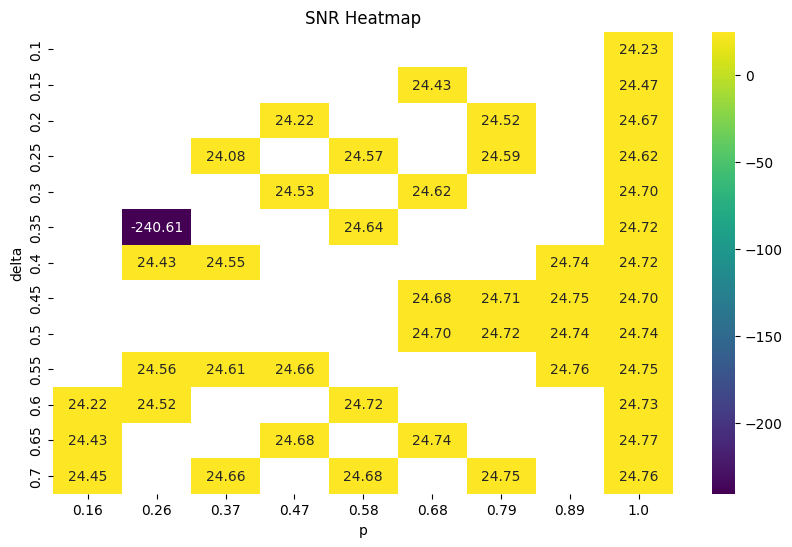

In [826]:
show_snr_lineplot(snr_full_df_r4)
show_snr_heatmap(snr_full_df_r4)

#### r=6

In [831]:
# Run for full dataframe
snr_full_df_r6 = comapare_CCS_SNR(W_dist_matrix, df, method=1, r=6)

/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul
  C = C @ (vh.T @ vh)
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul
  C = C @ (vh.T @ vh)
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul


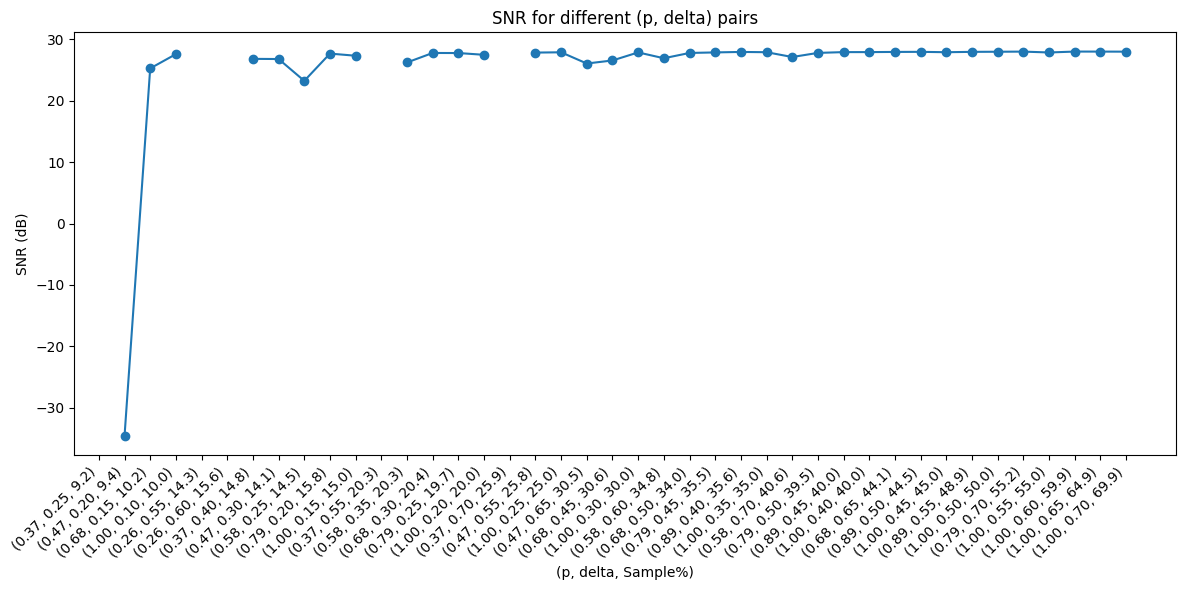

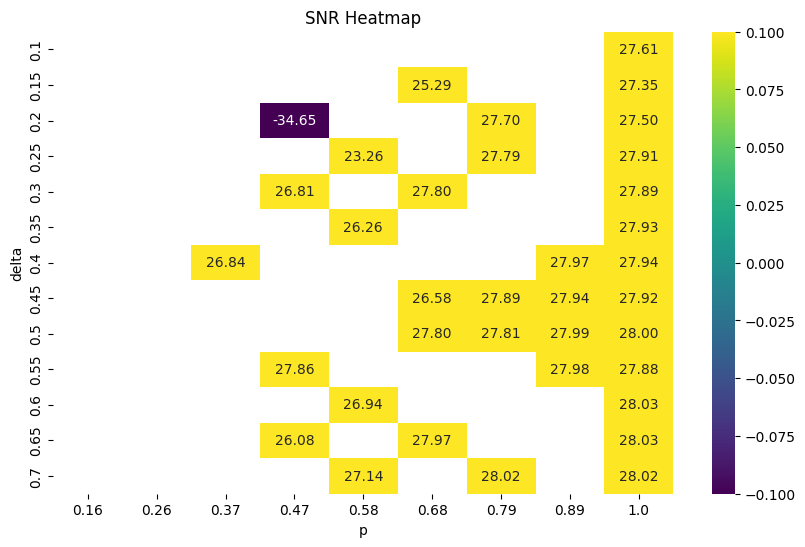

In [832]:
show_snr_lineplot(snr_full_df_r6)
show_snr_heatmap(snr_full_df_r6)

#### r=10

In [827]:
# Run for full dataframe
snr_full_df_r10 = comapare_CCS_SNR(W_dist_matrix, df, method=1, r=10)

/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul
  C = C @ (vh.T @ vh)
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul
  C = C @ (vh.T @ vh)
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  

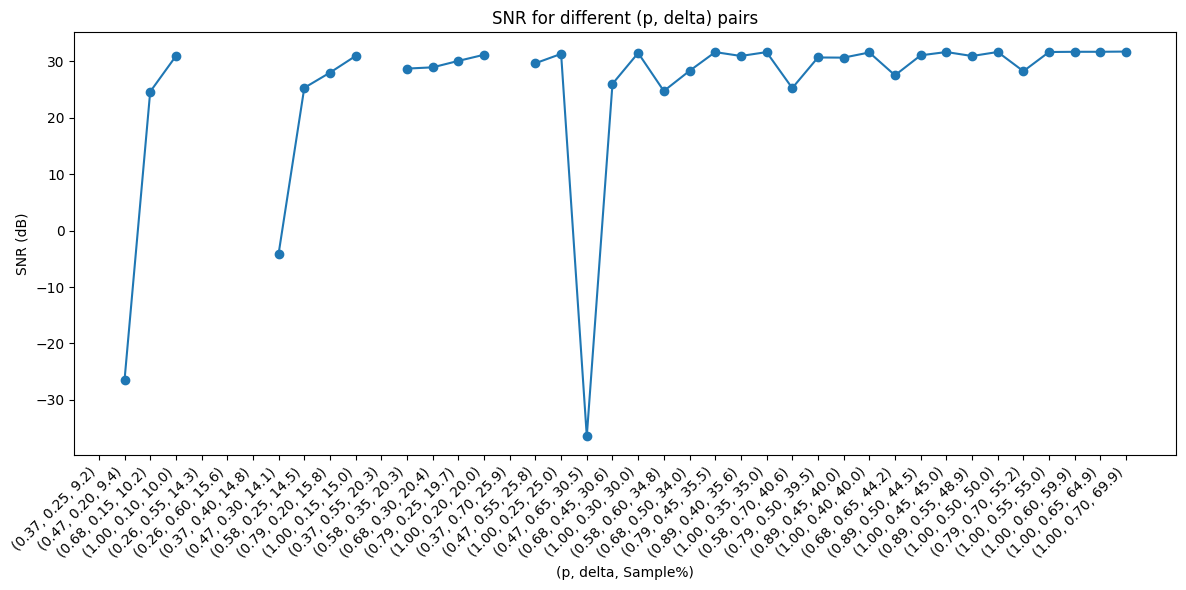

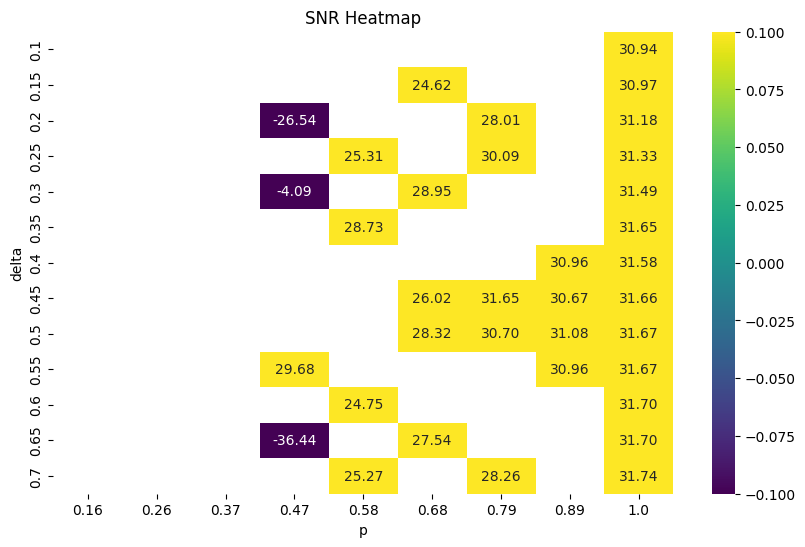

In [828]:
show_snr_lineplot(snr_full_df_r10)
show_snr_heatmap(snr_full_df_r10)

In [829]:
snr_unique_df_r10 = comapare_CCS_SNR(W_dist_matrix, unique_df, method=1, r=10)
#snr_unique_df

/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul
  C = C @ (vh.T @ vh)
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul
  C = C @ (vh.T @ vh)
/tmp/ipykernel_2071767/508499923.py:129: RuntimeWarning: overflow encountered in multiply
  C_flat[Omega_col] = (1 - eta[0]) * C_flat[Omega_col] + eta[0] * L_obs_col_vec
/tmp/ipykernel_2071767/508499923.py:79: RuntimeWarning: invalid value encountered in matmul


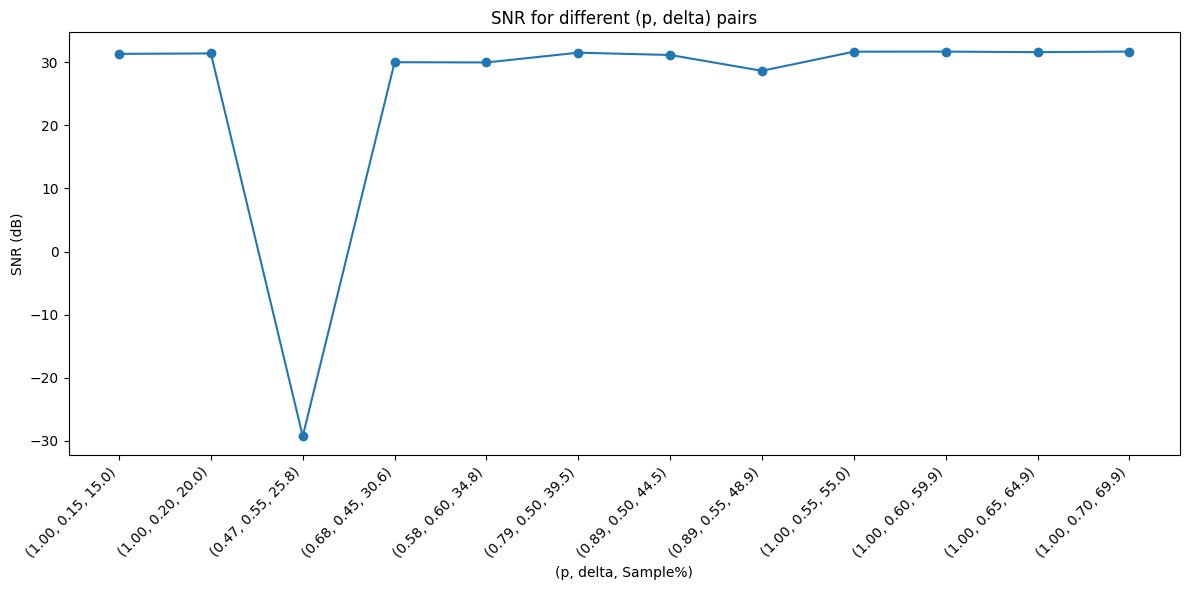

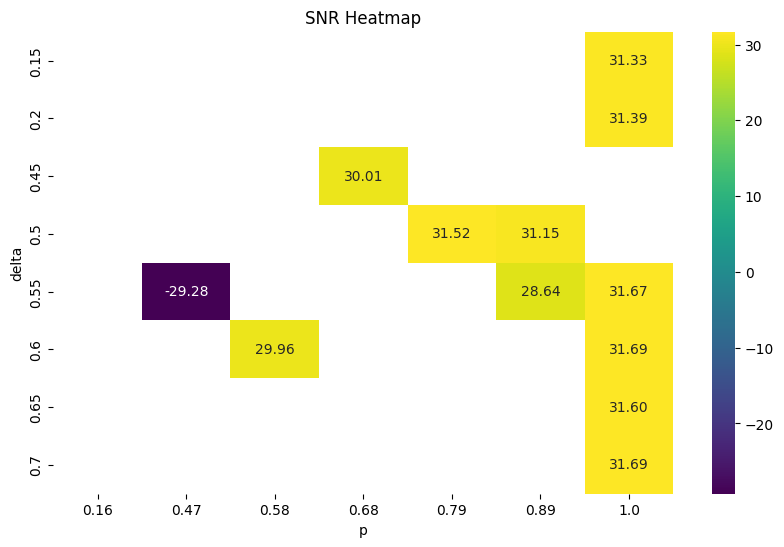

In [830]:
show_snr_lineplot(snr_unique_df_r10)
show_snr_heatmap(snr_unique_df_r10)

More samples: 10% to 40% with an increment of 2%

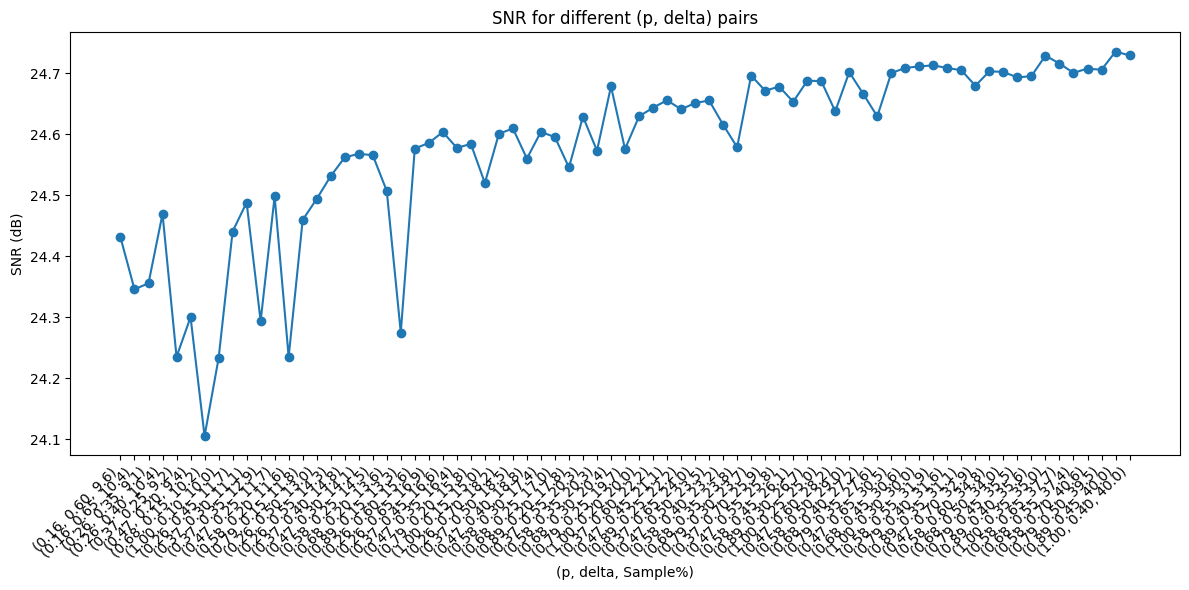

In [755]:
show_snr_lineplot(snr_full_df)

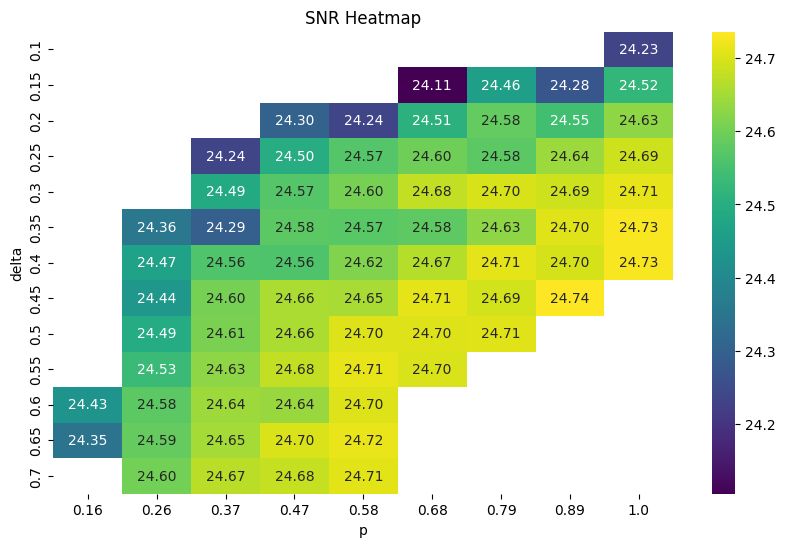

In [807]:
# Create a pivot table for heatmap
heatmap_data = snr_full_df.pivot(index='delta', columns='p', values='SNR')
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis')
plt.xlabel('p')
plt.ylabel('delta')
plt.title('SNR Heatmap')
plt.show()

#### Tests with a selected p,delta values

In [846]:
params_CCS = {'p': 0.76, 'delta': 0.25}
params_ICURC = {
        'eta': [1 / params_CCS['p'], 1 / params_CCS['p'], 1 / (2 * params_CCS['p'])],
        'TOL': 1e-4,
        'max_ite': 100
}
r = 4

# Run for all instances in the point_clouds
X_Omega_ccs_f, J_ccs_f, sampled_positions_f, C_Obs_f = CCS(W_dist_matrix, params_CCS)
#visualize_distance_matrix(X_Omega_ccs_f, title="Column only CCS on full distance matrix")
#print("Matrix completion in progress.....")
C, U_pinv, ICURC_time = ICURC(X_Omega_ccs_f, J_ccs_f, r, params_ICURC)
Mout_CURf = C @ U_pinv @ C.T
# Compute Signal to Noise Ratio
ccs_f_snr = compute_snr_db(W_dist_matrix, Mout_CURf)
print(f" SNR (in db) : {ccs_f_snr:.4f}; Total recovery time - {ICURC_time:.4f} seconds")

 SNR (in db) : 24.5311; Total recovery time - 1.1243 seconds


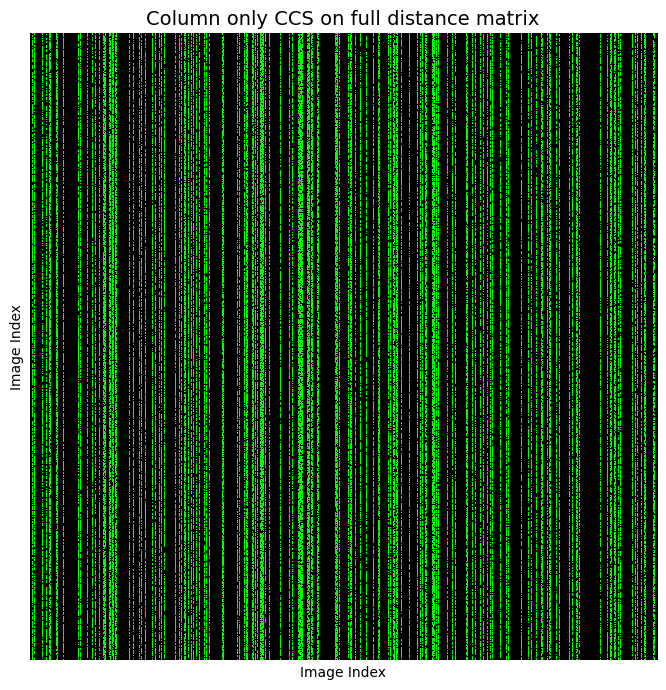

In [847]:
visualize_distance_matrix(X_Omega_ccs_f, title="Column only CCS on full distance matrix")

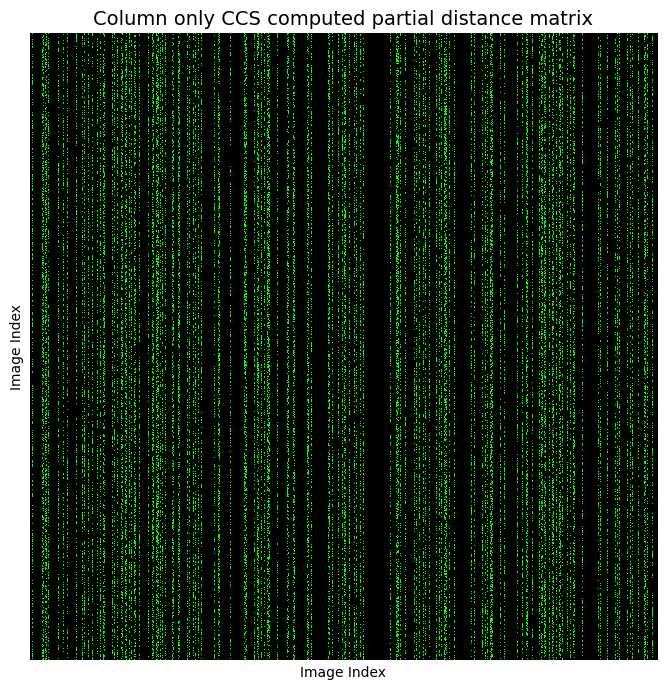

In [860]:
visualize_distance_matrix(X_Omega_ccs, title="Column only CCS-computed partial distance matrix")

In [859]:
len(sampled_positions)

92413

In [858]:
len(sampled_positions_f)

189813

In [854]:
len(J_ccs)

250

In [855]:
len(J_ccs_f)

250

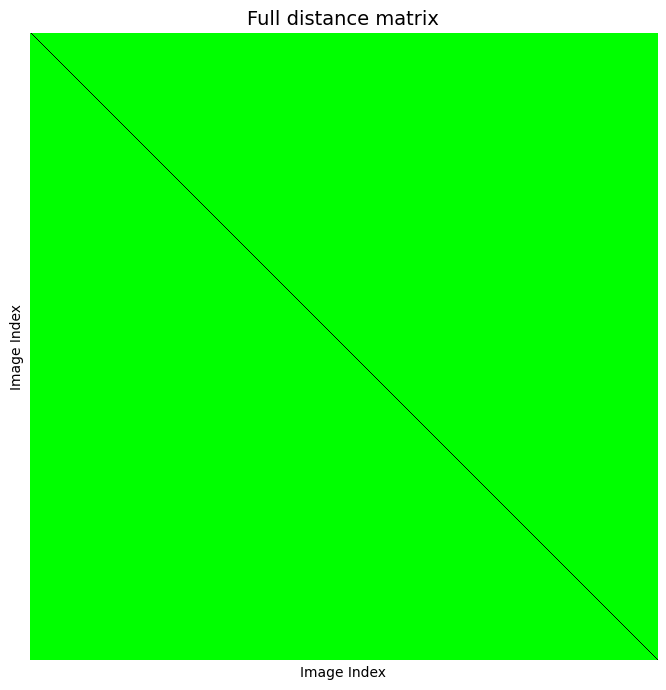

In [762]:
visualize_distance_matrix(W_dist_matrix, title="Full distance matrix", highlight_color='lime')

Sampling rate vs Recovery Time

In [765]:
snr_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   p                   74 non-null     float64
 1   delta               74 non-null     float64
 2   SamplePercentage    74 non-null     int64  
 3   SNR                 73 non-null     float64
 4   RecoveryTime(secs)  74 non-null     float64
 5   CCS_Sample%         74 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 3.6 KB


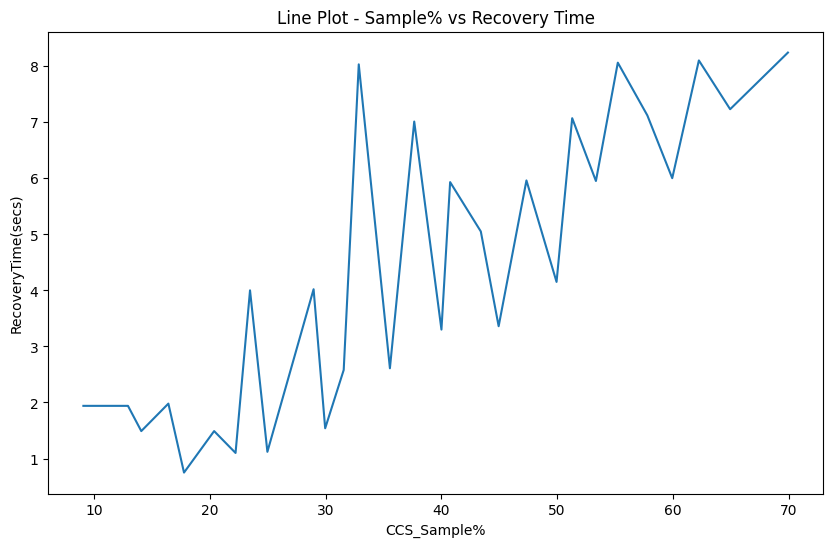

In [773]:
plt.figure(figsize=(10,6))
sns.lineplot(data=snr_unique_df, x="CCS_Sample%", y="RecoveryTime(secs)")
plt.title("Line Plot - Sample% vs Recovery Time")
plt.show()

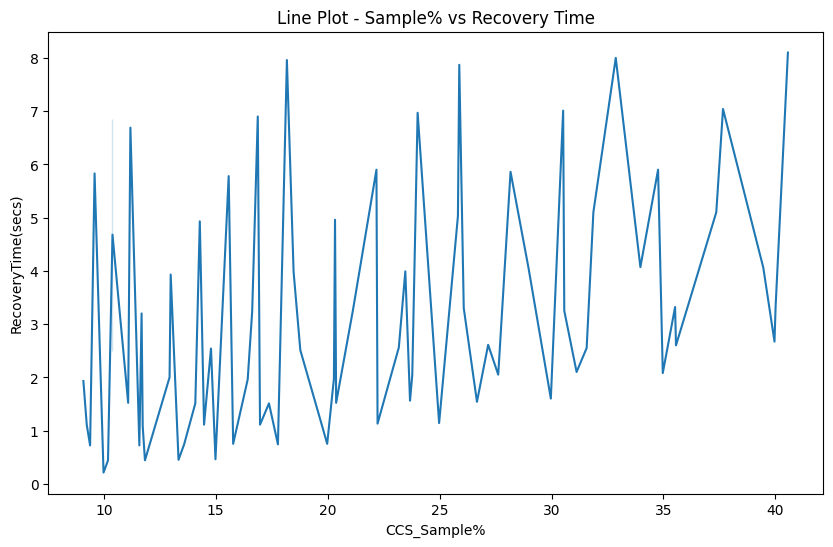

In [782]:
# Create line plot
plt.figure(figsize=(10,6))
sns.lineplot(data=snr_full_df, x="CCS_Sample%", y="RecoveryTime(secs)")
plt.title("Line Plot - Sample% vs Recovery Time")
plt.show()

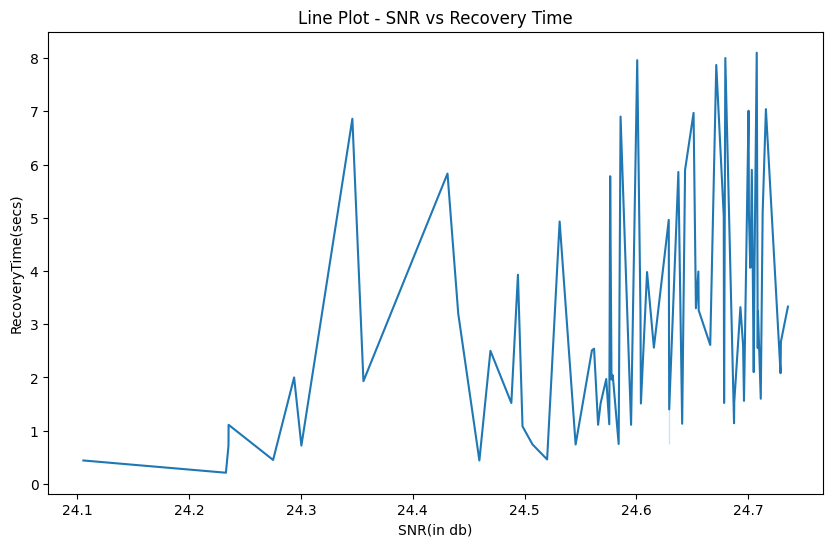

In [781]:
plt.figure(figsize=(10,6))
sns.lineplot(data=snr_full_df, x="SNR", y="RecoveryTime(secs)")
plt.title("Line Plot - SNR vs Recovery Time")
plt.xlabel('SNR(in db)')
plt.show()

### Other tests

#### Note: Continuation from ImageNet_Timing_SNR_comparisonv2.ipynb notebook

#### Uniform Random Sampling (per image)

##### Uniform random sampling - Partial distance matrix computation

In [1286]:
def compute_parital_wasserstein_matrix(point_clouds, sample_fraction=0.3, reg=1, seed=42):
    """
    Compute pairwise Wasserstein (Sinkhorn) distances between point clouds using POT,
    with uniform random sampling of points from each cloud.
    """
    rng = np.random.default_rng(seed)
    n = len(point_clouds)
    dist_matrix = np.zeros((n, n), dtype=np.float32)
    print(f"Computing Wasserstein distance matrix for {n} point clouds (sampling {sample_fraction*100:.1f}% points each).")
    for i in tqdm(range(n), desc="Computing distances"):
        Xi = point_clouds[i][:, :2]
        wi = point_clouds[i][:, 2]
        wi = wi / wi.sum() if wi.sum() > 0 else np.ones_like(wi) / len(wi)

        # Uniformly sample points from point cloud i
        n_i = int(len(Xi) * sample_fraction)
        idx_i = rng.choice(len(Xi), n_i, replace=False)
        Xi_s, wi_s = Xi[idx_i], wi[idx_i]
        wi_s = wi_s / wi_s.sum()

        for j in range(i + 1, n):
            Xj = point_clouds[j][:, :2]
            wj = point_clouds[j][:, 2]
            wj = wj / wj.sum() if wj.sum() > 0 else np.ones_like(wj) / len(wj)

            # Uniformly sample points from point cloud j
            n_j = int(len(Xj) * sample_fraction)
            idx_j = rng.choice(len(Xj), n_j, replace=False)
            Xj_s, wj_s = Xj[idx_j], wj[idx_j]
            wj_s = wj_s / wj_s.sum()

            # Compute cost matrix (squared Euclidean distance)
            M = ot.dist(Xi_s, Xj_s, metric='euclidean') ** 2
            W_dist = ot.sinkhorn2(wi_s, wj_s, M, reg=reg)
            dist_matrix[i, j] = dist_matrix[j, i] = np.sqrt(W_dist)

    return dist_matrix

#### Matrix Recovery tests

 SNR (in db) : 10.8638; Total recovery time - 0.8125 seconds


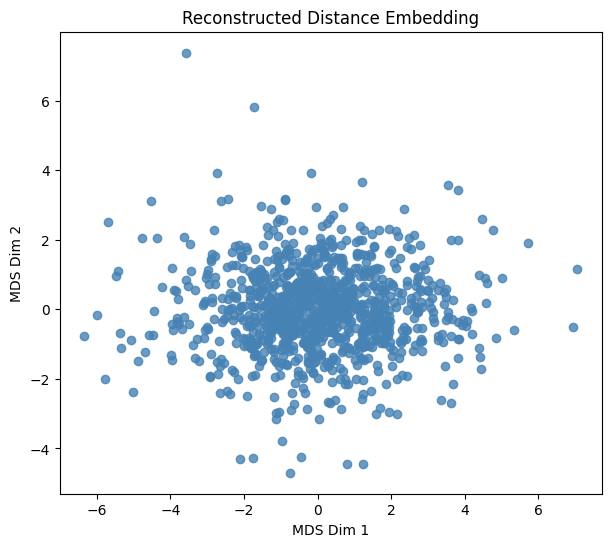

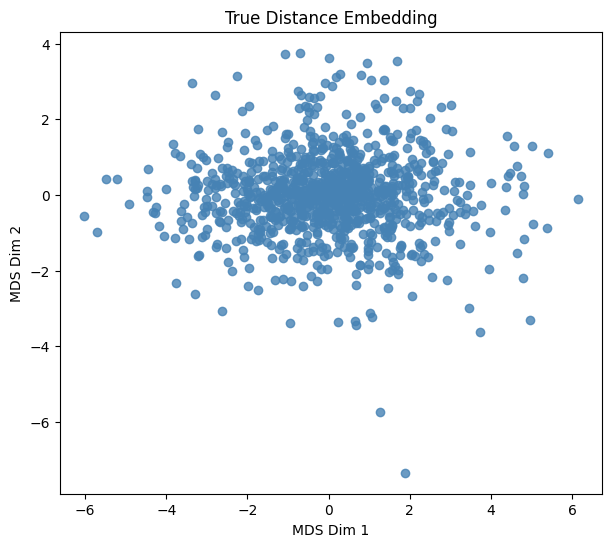

In [1287]:
uni3_nan_snr, uni3_nan_recon_time = matrix_recon_SNR(W_dist_matrix, W_uni3_partial_nan, see_embeddings=True)

In [1289]:
W_uni3_partial_zd = W_uni3_partial_nan.copy()
np.fill_diagonal(W_uni3_partial_zd, 0)

In [1290]:
uni3_nan_snr, uni3_nan_recon_time = matrix_recon_SNR(W_dist_matrix, W_uni3_partial_zd)

/home/axk8440@uta.edu/.local/lib/python3.10/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


 SNR (in db) : 10.9062; Total recovery time - 23.9702 seconds


#### Draft code

In [1291]:
#! pip install fancyimpute

def MDS(distance_matrix, num_components = 2, squared = False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    num_components corresponds to the embedding dimension, which is defaulted to 2
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding


from fancyimpute import SoftImpute
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="fancyimpute")

# Matrix Completion using SoftImpute (Efficient Alternative)
def recover_with_softimpute(D_obs, mds_function = MDS):  # Modify to just return D_filled
    model = SoftImpute(verbose = False)
    D_filled = model.fit_transform(D_obs)
    # return embed_with_mds(D_filled)
    return D_filled #mds_function(D_filled)

# Generic Recovery Wrapper
def recover_matrix(D_obs, method = 'softimpute', mds_function = MDS):
    if method == 'cvx':
        rank = kwargs.get('rank', 2)
        return recover_low_rank_embedding(D_obs, rank)
    elif method == 'softimpute':
        return recover_with_softimpute(D_obs)
    else:
        raise ValueError(f"Unknown recovery method: {method}")

def compute_snr_db_masked(W_true, W_recon, mask_obs):
    mask = mask_obs.astype(bool)
    signal = np.linalg.norm(W_true[mask])
    noise = np.linalg.norm((W_true - W_recon)[mask])
    if noise <= 0:
        return np.inf
    return 20 * np.log10(signal / noise)

In [ ]:
from scipy.spatial.distance import pdist, squareform

tic = time.perf_counter()
D_filled_uniform = recover_matrix(W_partial_uniform_dist, method='softimpute')
recovered_embedding_uniform = MDS(D_filled_uniform)
# Reconstruct distances from embedding
D_recon_uni = squareform(pdist(recovered_embedding_uniform, metric='euclidean'))
toc = time.perf_counter()
total_recovery_uniform = toc - tic

# Compute SNR
mask_obs_uni = ~np.isnan(W_partial_uniform_dist)
snr_db_uni = compute_snr_db_masked(W_dist_matrix, D_recon_uni, mask_obs_uni)
print(f" SNR (in db) : {snr_db_uni:.4f}; Total recovery time - {total_recovery_uniform:.4f} seconds")

- `W_partial` → partial Wasserstein distance matrix (some entries missing or computed via sampling).
- `D_filled` → matrix after SoftImpute (or other matrix recovery) → a reconstructed full distance matri
- `recovered_embedding` is a low-dimensional embedding of your images in Euclidean space, say shape (N, d).
- The idea of `MDS` is: it tries to preserve the distance relationships in a low-dimensional Euclidean representation.
- Each row in `recovered_embedding` corresponds to a point/image in a d-dimensional Euclidean space.
- 
The distances between points  `recovered_embedding`mb are an approximation of the original Wasserstein distance

**Notes:**
The above code 
- computes pairwise distances between all points in the embedding.
- convert the condensed distance vector into a square (N, N) distance matrix.s.x.